# Загрузка данных и обработка датасета, добавление всех фичей

Загружаю нужные библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.tsa.stattools import acf
from math import sqrt
import plotly.express as px
from tqdm import tqdm
from google.colab import drive
from xgboost import XGBRegressor
!pip install pandas_ta
import pandas_ta as ta
import matplotlib.pyplot as plt
from xgboost import plot_importance
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загружаем запаршенные котировки с API moex (final_data2 содержит информацию по свечам)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final_data2.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [ ]:
df['datetime'] = pd.to_datetime(df['begin']) + pd.Timedelta(minutes=1)
df = df.drop(columns = ['begin', 'end'])
df = df.sort_values(by = 'datetime')

Далее напишем заранее функцию определения паттерна тех. анализа

In [ ]:
def identify_pattern(data):
    """Определяет паттерн на основе последних 120 минут данных."""
    sma_10 = data['SMA_10'].iloc[-1]
    sma_30 = data['SMA_30'].iloc[-1]
    rsi = data['RSI'].iloc[-1]
    cdl_doji = data['CDLDOJI'].iloc[-1]

    if sma_10 > sma_30 and rsi < 30:
        return "Восходящий тренд с перепроданностью"
    elif sma_10 < sma_30 and rsi > 70:
        return "Восходящий тренд с перекупленностью"
    elif cdl_doji != 0:
        return "Формирование Doji"
    elif rsi < 30:
        return "Перепроданность"
    elif rsi > 70:
        return "Перекупленность"
    else:
        return "Нет четкого паттерна"


Как в прошлый раз проходим с окном и записываем данные временных рядов в двумерном виде

In [ ]:
def create_windowed_df(df, window_size1, window_size2, lag):
    result = []
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'value': 'sum',
        'volume': 'sum'
    }

    for ticker in df['ticker'].unique():
        ticker_df = df[df['ticker'] == ticker].reset_index(drop=True)
        ticker_df['datetime'] = pd.to_datetime(ticker_df['datetime'])
        ticker_df = ticker_df.set_index('datetime')

        ticker_df['SMA_10'] = ta.sma(ticker_df['close'], length=10)
        ticker_df['SMA_30'] = ta.sma(ticker_df['close'], length=30)
        ticker_df['EMA_10'] = ta.ema(ticker_df['close'], length=10)
        ticker_df['RSI'] = ta.rsi(ticker_df['close'], length=14)
        macd = ta.macd(ticker_df['close'], fast=12, slow=26)
        ticker_df['MACD'] = macd['MACD_12_26_9']

        ticker_df['CDLDOJI'] = ta.cdl_doji(ticker_df['open'], ticker_df['high'], ticker_df['low'], ticker_df['close'])

        # Проходим по данным с шагом lag
        for i in tqdm(range(window_size2, len(ticker_df)-60, lag)):
            # Данные для окна X минут поминутно
            last_120_minutes = ticker_df.iloc[i-window_size1:i]
            pattern_name = identify_pattern(last_120_minutes)

            window_data1 = ticker_df.iloc[i-window_size1:i][['open', 'high', 'low', 'close', 'value', 'volume']].values.flatten()

            # Данные для окна X часов почасно
            hourly_data = ticker_df.iloc[i-window_size2:i]
            aggregated_data = hourly_data.groupby(np.arange(len(hourly_data)) // 60).agg(agg_dict)
            window_data2 = aggregated_data.values.flatten()

            current_ticker = ticker
            current_datetime = ticker_df.index[i]

            target = ticker_df.iloc[i+60]['close'] # таргет - цена закрытия текущего часа

            sma_10 = ticker_df.iloc[i]['SMA_10']
            sma_30 = ticker_df.iloc[i]['SMA_30']
            ema_10 = ticker_df.iloc[i]['EMA_10']
            rsi = ticker_df.iloc[i]['RSI']
            macd_value = ticker_df.iloc[i]['MACD']

            cdl_doji = ticker_df.iloc[i]['CDLDOJI']

            result.append([target, current_ticker, current_datetime, sma_10, sma_30, ema_10, rsi, macd_value, cdl_doji, pattern_name] + list(window_data1) + list(window_data2))

    indicator_columns = ['SMA_10', 'SMA_30', 'EMA_10', 'RSI', 'MACD', 'CDLDOJI', 'pattern_name']

    window_columns1 = [f'{feature}_minute_{j}' for j in range(window_size1) for feature in ['open', 'high', 'low', 'close', 'value', 'volume']]
    num_hours = int(window_size2 / 60)
    window_columns2 = [f'{feature}_hour_{j}' for j in range(num_hours) for feature in ['open', 'high', 'low', 'close', 'value', 'volume']]

    all_columns = ['target','ticker', 'datetime'] + indicator_columns + window_columns1 + window_columns2
    return pd.DataFrame(result, columns=all_columns)

indicator_columns = ['SMA_10', 'SMA_30', 'EMA_10', 'RSI', 'MACD', 'CDLDOJI', 'pattern_name']

window_size1 = 90
window_size2 = 28 * 60
windowed_df = create_windowed_df(df, window_size1=window_size1, window_size2 = window_size2, lag=181)

100%|██████████| 268/268 [00:01<00:00, 266.72it/s]


In [ ]:
window_size1 = 90
window_size2 = 28 * 60

In [ ]:
windowed_df.to_csv('/content/drive/MyDrive/windowed_niceeee1.csv')

# Доп фичи из датасетов

Загружаем дополнительные датасеты, запаршенные по API Moex

In [ ]:
import os
data_dir = '/content/drive/MyDrive/dfs_stocks'

files = os.listdir(data_dir)

dataframes = {}

for file in files:
      df_name = file.split('.')[0]  # Имя DataFrame будет названием файла без расширения
      file_path = os.path.join(data_dir, file)  # Полный путь к файлу
      if file_path != '/content/drive/MyDrive/dfs_stocks/plots':
        dataframes[df_name] = pd.read_csv(file_path)

df_gold = pd.read_csv('/content/drive/MyDrive/df_gold.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/df_oil.csv')
df_usd = pd.read_csv('/content/drive/MyDrive/df_usd.csv')
df_moex = pd.read_csv('/content/drive/MyDrive/df_moex.csv')

df_gold['datetime'] = pd.to_datetime(df_gold['datetime'])
df_oil['datetime'] = pd.to_datetime(df_oil['datetime'])
df_usd['datetime'] = pd.to_datetime(df_usd['end'])
df_usd.drop(columns=['end', 'begin', 'Unnamed: 0', 'open', 'high', 'low', 'value', 'volume'], inplace=True)
df_moex['datetime'] = pd.to_datetime(df_moex['datetime'])

df_news = pd.read_csv('/content/drive/MyDrive/Updated_Data_with_Split_Sentiments.csv')

In [ ]:
df_gold = df_gold.sort_values(by = 'datetime')
df_oil = df_oil.sort_values(by = 'datetime')
df_usd = df_usd.sort_values(by = 'datetime')
df_moex = df_moex.sort_values(by = 'datetime')

In [ ]:
df_news['datetime'] = pd.to_datetime(df_news['data and time'])
df_news.sort_values(by='datetime')

,title,link,data and time,SBER_sentiment_neg,SBER_sentiment_neutral,SBER_sentiment_pos,AGRO_sentiment_neg,AGRO_sentiment_neutral,AGRO_sentiment_pos,CHMF_sentiment_neg,...,SMLT_sentiment_neg,SMLT_sentiment_neutral,SMLT_sentiment_pos,VKCO_sentiment_neg,VKCO_sentiment_neutral,VKCO_sentiment_pos,YNDX_sentiment_neg,YNDX_sentiment_neutral,YNDX_sentiment_pos,datetime
8739,Доллар: вот и долетался,https://bcs-express.ru/novosti-i-analitika/dol...,2024-01-21 00:20:32,0.351546,0.296325,0.352129,0.318781,0.360164,0.321055,0.348340,...,0.245605,0.408243,0.346152,0.370111,0.256741,0.373147,0.315929,0.309141,0.374929,2024-01-21 00:20:32
8728,"Ход торгов. Рынок акций просел, ОФЗ продолжают...",https://bcs-express.ru/novosti-i-analitika/kho...,2024-01-21 01:08:11,0.372599,0.291989,0.335412,0.323709,0.347205,0.329087,0.349805,...,0.264279,0.417675,0.318046,0.398470,0.246392,0.355137,0.316978,0.322986,0.360036,2024-01-21 01:08:11
8730,По инерции — смогут ли топ-5 лидеров недели пр...,https://bcs-express.ru/novosti-i-analitika/172...,2024-01-21 01:33:07,0.397654,0.281663,0.320683,0.333528,0.335777,0.330696,0.345228,...,0.270985,0.424143,0.304872,0.406075,0.242076,0.351848,0.312027,0.338745,0.349229,2024-01-21 01:33:07
8741,Транснефть-ап. Ожидается консолидация на текущ...,https://bcs-express.ru/tehanaliz/trnfp/16.08.24,2024-01-21 01:51:29,0.310009,0.308614,0.381377,0.297714,0.391666,0.310620,0.354291,...,0.227886,0.370488,0.401626,0.344417,0.272393,0.383190,0.325592,0.285907,0.388500,2024-01-21 01:51:29
8756,Мосбиржа объявила дату начала торгов акциями М...,https://bcs-express.ru/novosti-i-analitika/izm...,2024-01-21 02:53:49,0.375181,0.289725,0.335094,0.327755,0.350425,0.321820,0.343555,...,0.267080,0.412575,0.320345,0.397870,0.254671,0.347459,0.317907,0.332122,0.349971,2024-01-21 02:53:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Срочный рынок. Рынок засеребрился,https://bcs-express.ru/novosti-i-analitika/sro...,2024-10-20 20:07:55,0.336925,0.298789,0.364286,0.314890,0.361474,0.323636,0.347188,...,0.249921,0.394503,0.355576,0.368350,0.259921,0.371729,0.320002,0.301241,0.378757,2024-10-20 20:07:55
22,Как принять участие в дополнительном выкупе ак...,https://bcs-express.ru/novosti-i-analitika/kak...,2024-10-20 20:45:14,0.376125,0.294173,0.329702,0.320379,0.335266,0.344356,0.356215,...,0.276830,0.411088,0.312082,0.404970,0.245271,0.349759,0.320182,0.324630,0.355188,2024-10-20 20:45:14
13,ЦБ предложил ввести универсальный QR-код,https://bcs-express.ru/novosti-i-analitika/tsb...,2024-10-20 21:29:39,0.373540,0.295605,0.330855,0.324792,0.355779,0.319429,0.340303,...,0.276420,0.411586,0.311993,0.405433,0.246991,0.347575,0.312708,0.331036,0.356256,2024-10-20 21:29:39
4,Опасный сигнал от рубля,https://bcs-express.ru/novosti-i-analitika/opa...,2024-10-20 23:02:01,0.370288,0.288981,0.340731,0.329008,0.345599,0.325393,0.352256,...,0.255788,0.423386,0.320826,0.389285,0.258653,0.352062,0.310787,0.328866,0.360347,2024-10-20 23:02:01


In [ ]:
list_news = ['SBER_sentiment_neg',
       'SBER_sentiment_neutral', 'SBER_sentiment_pos', 'AGRO_sentiment_neg',
       'AGRO_sentiment_neutral', 'AGRO_sentiment_pos', 'CHMF_sentiment_neg',
       'CHMF_sentiment_neutral', 'CHMF_sentiment_pos', 'MTSS_sentiment_neg',
       'MTSS_sentiment_neutral', 'MTSS_sentiment_pos', 'SIBN_sentiment_neg',
       'SIBN_sentiment_neutral', 'SIBN_sentiment_pos', 'SMLT_sentiment_neg',
       'SMLT_sentiment_neutral', 'SMLT_sentiment_pos', 'VKCO_sentiment_neg',
       'VKCO_sentiment_neutral', 'VKCO_sentiment_pos', 'YNDX_sentiment_neg',
       'YNDX_sentiment_neutral', 'YNDX_sentiment_pos']
indicator_columns = ['SMA_10', 'SMA_30', 'EMA_10', 'RSI', 'MACD', 'CDLDOJI', 'pattern_name']


In [ ]:
list_orderstats = ['put_orders_b', 'put_orders_s', 'put_val_b', 'put_val_s', 'put_vol_b',
       'put_vol_s', 'put_vwap_b', 'put_vwap_s', 'put_vol', 'put_val',
       'put_orders', 'cancel_orders_b', 'cancel_orders_s', 'cancel_val_b',
       'cancel_val_s', 'cancel_vol_b', 'cancel_vol_s', 'cancel_vwap_b',
       'cancel_vwap_s', 'cancel_vol', 'cancel_val']

list_tradestats = ['pr_vwap', 'pr_change', 'trades_b', 'trades_s', 'val_b',
       'val_s', 'vol_b', 'vol_s', 'disb', 'pr_vwap_b', 'pr_vwap_s',
       'sec_pr_open', 'sec_pr_high', 'sec_pr_low', 'sec_pr_close']


list_obstats = ['spread_bbo', 'spread_lv10', 'spread_1mio', 'levels_b', 'levels_s',
       'vol_b', 'vol_s', 'val_b', 'val_s', 'imbalance_vol_bbo',
       'imbalance_val_bbo', 'imbalance_vol', 'imbalance_val', 'vwap_b',
       'vwap_s', 'vwap_b_1mio', 'vwap_s_1mio']

Размечаем датасет

In [ ]:
final_df = pd.DataFrame()
for ticker in tqdm(windowed_df['ticker'].unique()):
  ticker_df = windowed_df[windowed_df['ticker'] == ticker].reset_index(drop=True)
  ticker_df['datetime'] = pd.to_datetime(ticker_df['datetime'])
  ticker_df = ticker_df.sort_values(by='datetime')

  df_tradestats = dataframes[f'df_{ticker}_TRADESTATS']
  df_HI2 = dataframes[f'df_{ticker}_HI2']
  df_OBSTATS = dataframes[f'df_{ticker}_OBSTATS']
  df_ORDERSTATS = dataframes[f'df_{ticker}_ORDERSTATS']
  if df_HI2.empty:
    pass
  else:
    df_HI2['datetime'] = pd.to_datetime(df_HI2['tradedate'] + ' ' + df_HI2['tradetime'])
    df_HI2_pivot = df_HI2.pivot_table(index=['tradedate', 'tradetime'], columns='metric', values='value').reset_index()
    df_HI2_pivot['datetime'] = pd.to_datetime(df_HI2_pivot['tradedate'] + ' ' + df_HI2_pivot['tradetime'])
    df_HI2_pivot = df_HI2_pivot.sort_values(by='datetime')


  df_tradestats['datetime'] = pd.to_datetime(df_tradestats['tradedate'] + ' ' + df_tradestats['tradetime'])
  df_tradestats = df_tradestats.sort_values(by='datetime')
  df_OBSTATS['datetime'] = pd.to_datetime(df_OBSTATS['tradedate'] + ' ' + df_OBSTATS['tradetime'])
  df_OBSTATS = df_OBSTATS.sort_values(by='datetime')
  df_ORDERSTATS['datetime'] = pd.to_datetime(df_ORDERSTATS['tradedate'] + ' ' + df_ORDERSTATS['tradetime'])
  df_ORDERSTATS = df_ORDERSTATS.sort_values(by='datetime')

  for index, row in ticker_df.iterrows():
        row_datetime = row['datetime']

        closest_OBSTATS_row = df_OBSTATS[df_OBSTATS['datetime'] <= row_datetime].iloc[-1]
        for col in list_obstats:
            ticker_df.loc[index, col] = closest_OBSTATS_row[col]  # Присоединяем выбранные колонки

        # Присоединяем ближайшую строку из df_tradestats
        closest_TRADESTATS_row = df_tradestats[df_tradestats['datetime'] <= row_datetime].iloc[-1]
        for col in list_tradestats:
            ticker_df.loc[index, col] = closest_TRADESTATS_row[col]  # Присоединяем выбранные колонки

        # Присоединяем ближайшую строку из df_ORDERSTATS
        closest_ORDERSTATS_row = df_ORDERSTATS[df_ORDERSTATS['datetime'] <= row_datetime].iloc[-1]
        for col in list_orderstats:
            ticker_df.loc[index, col] = closest_ORDERSTATS_row[col]


        if len(df_HI2_pivot[df_HI2_pivot['datetime'] <= row_datetime]) > 0:
          closest_HI2_row = df_HI2_pivot[df_HI2_pivot['datetime'] <= row_datetime].iloc[-1]
        if df_HI2.empty:
          pass
        else:
          for col in df_HI2_pivot.columns:
              if col not in ['datetime', 'tradedate', 'tradetime']:  # Пропускаем служебные колонки
                  ticker_df.loc[index, col] = closest_HI2_row[col]

        if len(df_gold[df_gold['datetime'] <= row_datetime]) > 0:
          closest_gold_row = df_gold[df_gold['datetime'] <= row_datetime].iloc[-1]
          ticker_df.loc[index, 'close_gold'] = closest_gold_row['close']
        else:
          ticker_df.loc[index, 'close_gold'] = None

        if len(df_oil[df_oil['datetime'] <= row_datetime]) > 0:
          closest_oil_row = df_oil[df_oil['datetime'] <= row_datetime].iloc[-1]
          ticker_df.loc[index, 'close_oil'] = closest_oil_row['close']
        else:
          ticker_df.loc[index, 'close_oil'] = None

        if len(df_usd[df_usd['datetime'] <= row_datetime]) > 0:
          closest_usd_row = df_usd[df_usd['datetime'] <= row_datetime].iloc[-1]
          ticker_df.loc[index, 'close_usd'] = closest_usd_row['close']
        else:
          ticker_df.loc[index, 'close_usd'] = None

        if len(df_moex[df_moex['datetime'] <= row_datetime]) > 0:
          closest_moex_row = df_moex[df_moex['datetime'] <= row_datetime].iloc[-1]
          ticker_df.loc[index, 'close_moex'] = closest_moex_row['close']
        else:
          ticker_df.loc[index, 'close_moex'] = None

        if len(df_news[df_news['datetime'] <= row_datetime]) > 0:
          closest_news_rows = df_news[(df_news['datetime'] <= row_datetime)&(df_news['datetime'] >= row_datetime - pd.Timedelta(weeks=1))]
          for col in list_news:
            ticker_df.loc[index, col] = closest_news_rows[col].mean()
        else:
          for col in list_news:
            ticker_df.loc[index, col] = None

  final_df = pd.concat([final_df, ticker_df], ignore_index=True)

100%|██████████| 8/8 [45:34<00:00, 341.80s/it]


In [ ]:
final_df.to_csv('/content/drive/MyDrive/final_data_23102024.csv')

# Функция подсчета

In [ ]:
# final_df = pd.read_csv('/content/drive/MyDrive/final_data_23101253.csv')
# final_df = final_df.drop(columns = ['Unnamed: 0'])
final_df['datetime'] = pd.to_datetime(final_df['datetime'])
final_df = final_df.sort_values(by = 'datetime')

Для удобного обучения множества моделей запишем все в функцию

In [ ]:
def count_xgboost_metrics(final_df, current_columns, cat_features, name_model):
  global df_metrics
  df_all = final_df.copy()
  df_all['day_of_week'] = df_all['datetime'].dt.day_name()
  df_all['hour'] = df_all['datetime'].dt.hour

  df_all = df_all[current_columns + ['ticker', 'datetime', 'target']]

  df_all_encoded = pd.get_dummies(df_all, columns=cat_features)

  df_train1 = df_all_encoded[df_all_encoded.datetime < '2024-01-01'].reset_index(drop=True)
  df_test1 = df_all_encoded[(df_all_encoded.datetime >= '2024-01-01')&(df_all_encoded.datetime < '2024-06-01')].reset_index(drop=True)

  df_train2 = df_all_encoded[df_all_encoded.datetime < '2024-06-01'].reset_index(drop=True)
  df_test2 = df_all_encoded[(df_all_encoded.datetime >= '2024-06-01')&(df_all_encoded.datetime < '2024-08-01')].reset_index(drop=True)

  df_train3 = df_all_encoded[df_all_encoded.datetime < '2024-08-01'].reset_index(drop=True)
  df_test3 = df_all_encoded[df_all_encoded.datetime >= '2024-08-01'].reset_index(drop=True)

  X_train1 = df_train1.drop(columns = ['target', 'datetime'])
  y_train1 = df_train1['target']
  X_test1 = df_test1.drop(columns = ['target', 'datetime'])
  y_test1 = df_test1['target']

  X_train2 = df_train2.drop(columns = ['target', 'datetime'])
  y_train2 = df_train2['target']
  X_test2 = df_test2.drop(columns = ['target', 'datetime'])
  y_test2 = df_test2['target']

  X_train3 = df_train3.drop(columns = ['target', 'datetime'])
  y_train3 = df_train3['target']
  X_test3 = df_test3.drop(columns = ['target', 'datetime'])
  y_test3 = df_test3['target']

  #__________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)
  print('Start training model 1')
  XGB.fit(X_train1, y_train1, verbose=True)

  predictions = XGB.predict(X_test1)

  mse1 = mean_squared_error(y_test1, predictions)
  rmse1 = np.sqrt(mse1)
  mae1 = mean_absolute_error(y_test1, predictions)
  mape1 = np.mean(np.abs((y_test1 - predictions) / y_test1)) * 100

  print(f'{name_model}, На первом сплите кросс валидации метрики на тесте\n')
  print(f"MSE: {mse1}")
  print(f"RMSE: {rmse1}")
  print(f"MAE: {mae1}")
  print(f"MAPE: {mape1}")
  print('_' * 40)

  #____________________________________________

  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)

  print('Start training model 2, (the second stage of validation)\n')

  XGB.fit(X_train2, y_train2, verbose=True)

  predictions = XGB.predict(X_test2)

  mse2 = mean_squared_error(y_test2, predictions)
  rmse2 = np.sqrt(mse2)
  mae2 = mean_absolute_error(y_test2, predictions)
  mape2 = np.mean(np.abs((y_test2 - predictions) / y_test2)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse2}")
  print(f"RMSE: {rmse2}")
  print(f"MAE: {mae2}")
  print(f"MAPE: {mape2}")
  print('_' * 40)


  #________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)

  print('Start training model 3, (the third stage of validation)\n')

  XGB.fit(X_train3, y_train3, verbose=True)

  predictions = XGB.predict(X_test3)

  mse3 = mean_squared_error(y_test3, predictions)
  rmse3 = np.sqrt(mse3)
  mae3 = mean_absolute_error(y_test3, predictions)
  mape3 = np.mean(np.abs((y_test3 - predictions) / y_test3)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse3}")
  print(f"RMSE: {rmse3}")
  print(f"MAE: {mae3}")
  print(f"MAPE: {mape3}")
  print('_' * 40)

  #______________________________________________

  if df_metrics is not None and not df_metrics.empty:
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            'Model': [name_model],
            'MSE1': [mse1],
            'RMSE1': [rmse1],
            'MAE1': [mae1],
            'MAPE1': [mape1],
            'MSE2': [mse2],
            'RMSE2': [rmse2],
            'MAE2': [mae2],
            'MAPE2': [mape2],
            'MSE3': [mse3],
            'RMSE3': [rmse3],
            'MAE3': [mae3],
            'MAPE3': [mape3]
        })], ignore_index=True)
  else:
        df_metrics = pd.DataFrame({
            'Model': [name_model],
            'MSE1': [mse1],
            'RMSE1': [rmse1],
            'MAE1': [mae1],
            'MAPE1': [mape1],
            'MSE2': [mse2],
            'RMSE2': [rmse2],
            'MAE2': [mae2],
            'MAPE2': [mape2],
            'MSE3': [mse3],
            'RMSE3': [rmse3],
            'MAE3': [mae3],
            'MAPE3': [mape3]
        })

  print('MEAN MAPE ON CROSS VAL: ', (mape1 + mape2 + mape3) / 3)
  print('_' * 40)


# Создаем три графика одного размера, расположенные друг под другом
  fig, axs = plt.subplots(3, 1, figsize=(10, 20))  # 3 строки, 1 колонка

  # Параметры для подписи осей
  importance_types = ['weight', 'gain', 'cover']
  titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']

  for i, importance_type in enumerate(importance_types):
      plt.sca(axs[i])  # Устанавливаем текущую ось
      plot_importance(XGB, importance_type=importance_type, max_num_features=10, ax=axs[i])
      axs[i].set_title(f'{titles[i]} {name_model}', fontsize=18)

      # Устанавливаем стиль для оси Y (названия фичей)
      for tick in axs[i].yaxis.get_majorticklabels():
          tick.set_fontsize(14)  # Размер шрифта для названий фичей
          tick.set_fontweight('bold')  # Жирный шрифт

  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/dfs_stocks/plots/{name_model}_feature_importance3.png')
  plt.show()

# Тестирование признаков

Далее для разных комбинаций признаков смотрю метрики, получаю графики feature importance

In [ ]:
df_metrics = pd.DataFrame(columns = [
            'Model',
            'MSE1',
            'RMSE1',
            'MAE1',
            'MAPE1',
            'MSE2',
            'RMSE2',
            'MAE2',
            'MAPE2',
            'MSE3',
            'RMSE3'
            ])

**Базовая модель - просто цены закрытия**

Start training model 1
Baseline_model, На первом сплите кросс валидации метрики на тесте

MSE: 672.6147532329213
RMSE: 25.934817393475537
MAE: 11.833300695425297
MAPE: 0.660905929161224
________________________________________
Start training model 2, (the second stage of validation)

Baseline_model, На втором сплите кросс валидации метрики на тесте
MSE: 642.1853767871381
RMSE: 25.341376773710188
MAE: 10.582639626397027
MAPE: 0.6688495130869703
________________________________________
Start training model 3, (the third stage of validation)

Baseline_model, На втором сплите кросс валидации метрики на тесте
MSE: 583.8258960385474
RMSE: 24.162489442078343
MAE: 11.687877592740428
MAPE: 0.755696042974133
________________________________________
MEAN MAPE ON CROSS VAL:  0.6951504950741091
________________________________________


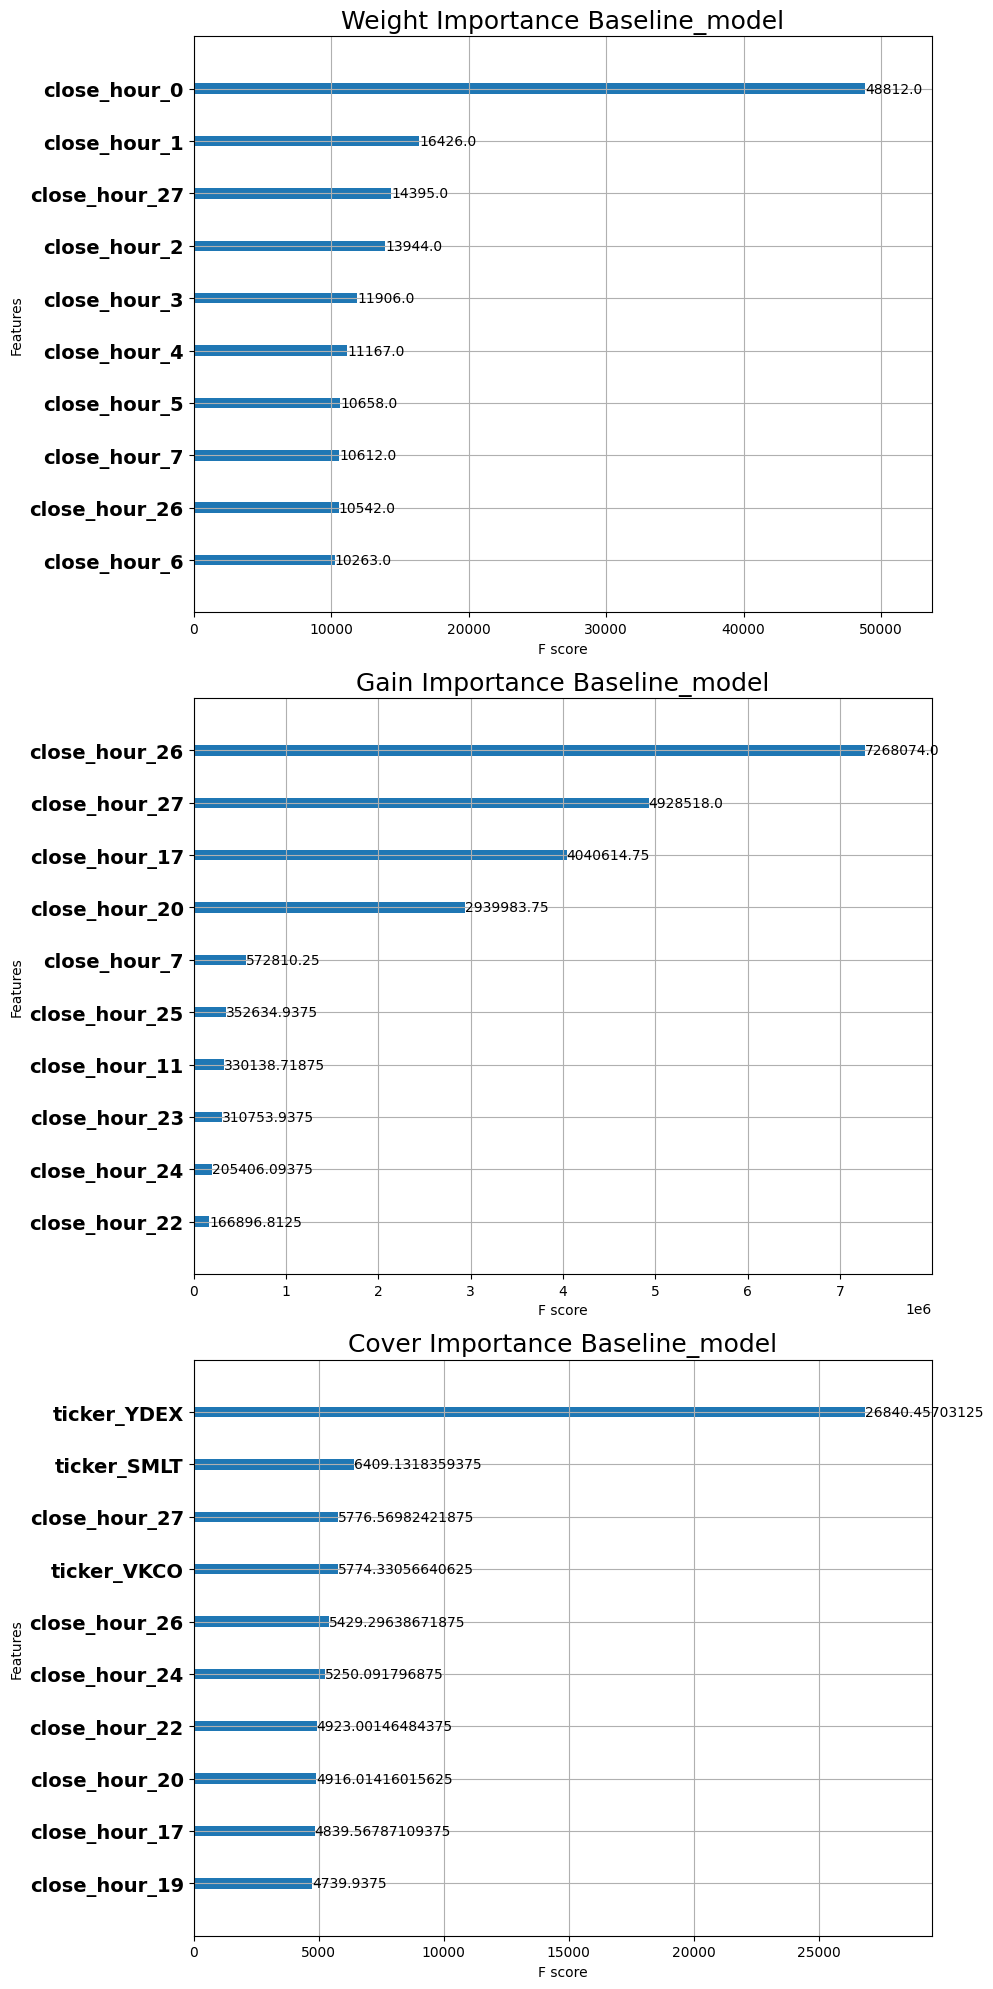

In [ ]:
window_columns1 = [f'{feature}_minute_{j}' for j in range(window_size1) for feature in ['open', 'high', 'low', 'close', 'value', 'volume']]
num_hours = int(window_size2 / 60)
window_columns2 = [f'{feature}_hour_{j}' for j in range(num_hours) for feature in ['open', 'high', 'low', 'close', 'value', 'volume']]

close_columns = [col for col in window_columns2 if 'close' in col]
current_columns = close_columns
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'Baseline_model')

**Добавление информации о дне недели**

Start training model 1
День недели, время, На первом сплите кросс валидации метрики на тесте

MSE: 800.3485701290992
RMSE: 28.29043248395293
MAE: 12.077830586789617
MAPE: 0.6643420351418264
________________________________________
Start training model 2, (the second stage of validation)

День недели, время, На втором сплите кросс валидации метрики на тесте
MSE: 603.0854752529003
RMSE: 24.55779866463809
MAE: 10.307341076886212
MAPE: 0.6520550809053717
________________________________________
Start training model 3, (the third stage of validation)

День недели, время, На втором сплите кросс валидации метрики на тесте
MSE: 882.7574190467446
RMSE: 29.71123388630544
MAE: 12.959328872910776
MAPE: 0.7547419022359881
________________________________________
MEAN MAPE ON CROSS VAL:  0.690379672761062
________________________________________


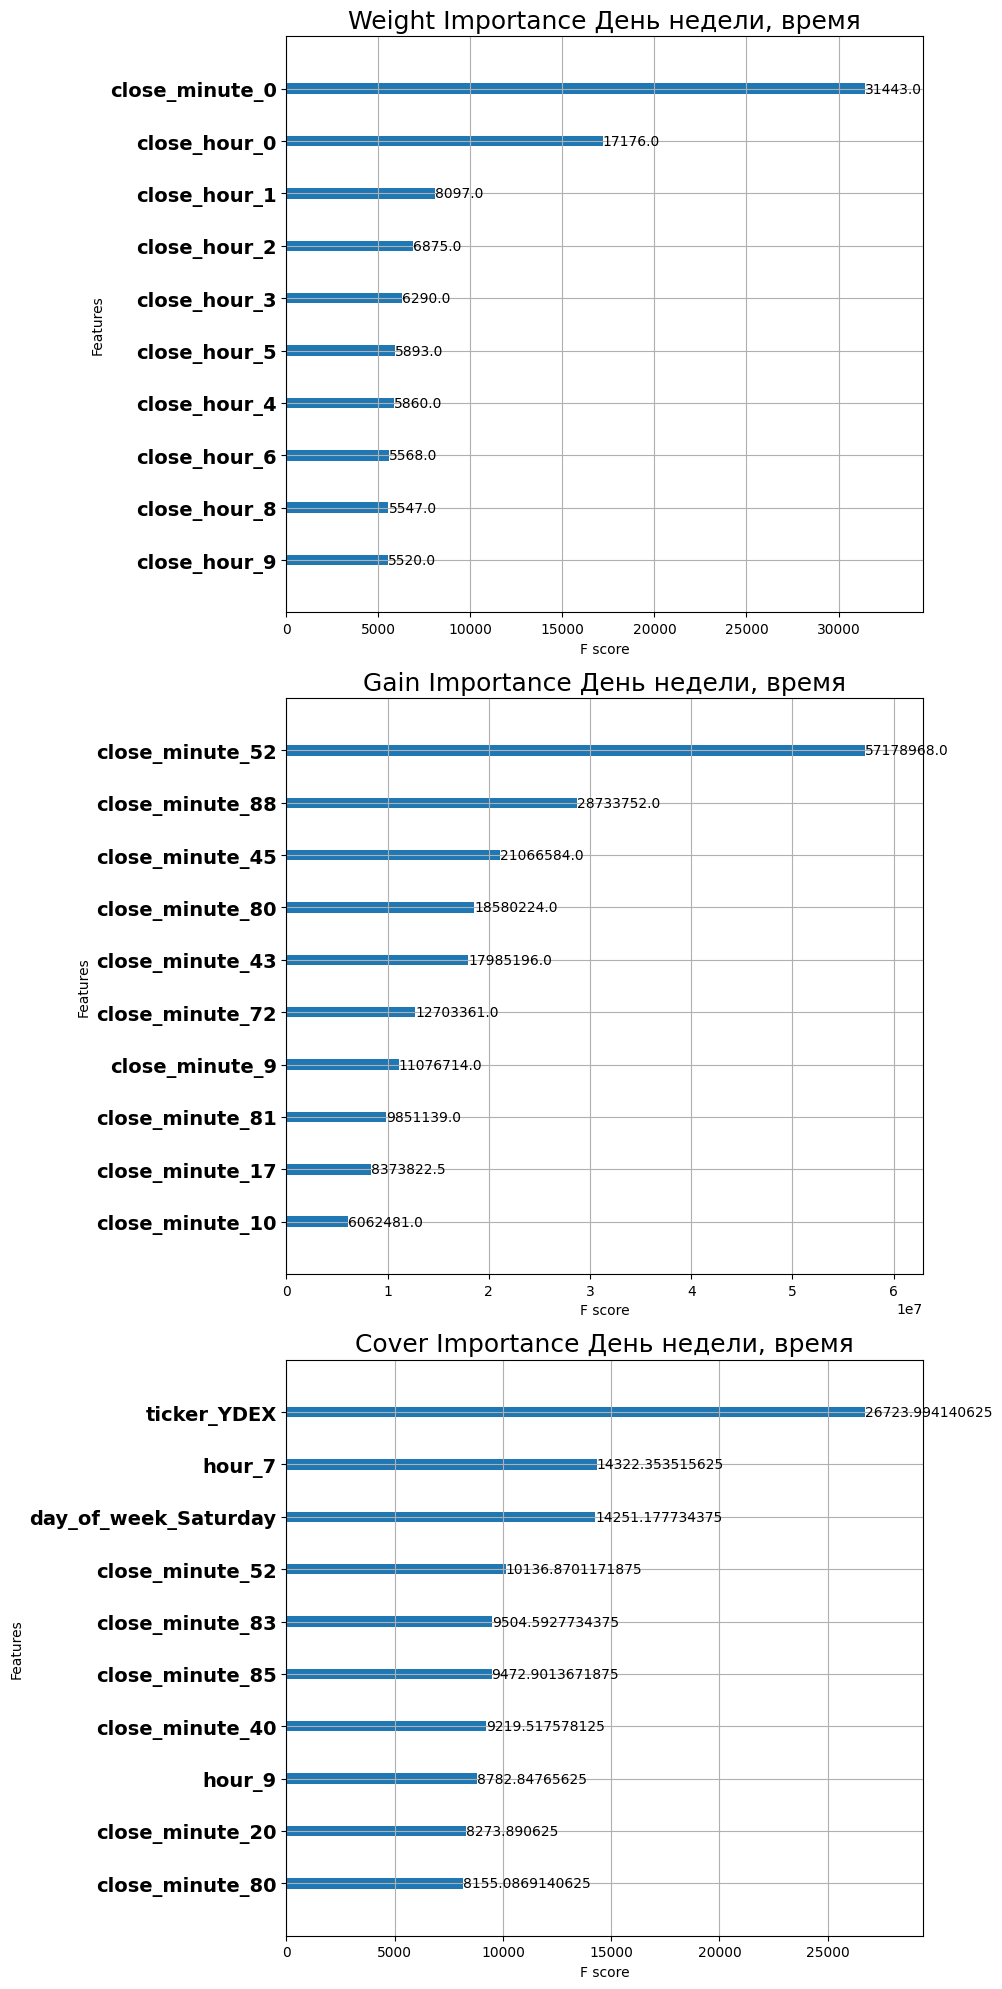

In [ ]:
close_columns = [col for col in window_columns1 + window_columns2 if 'close' in col]

current_columns = close_columns +  ['day_of_week', 'hour']
cat_features = ['ticker'] +  ['day_of_week', 'hour']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'День недели, время')

**Добавление подробной информации о свечах**

In [ ]:
current_columns = window_columns1 + window_columns2

cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'С полной информацией о свечах')

Start training model 1
С полной информацией о свечах, На первом сплите кросс валидации метрики на тесте

MSE: 627.3499204191448
RMSE: 25.0469543142304
MAE: 11.13984974776733
MAPE: 0.6280115161511938
________________________________________
Start training model 2, (the second stage of validation)

С полной информацией о свечах, На втором сплите кросс валидации метрики на тесте
MSE: 559.1775429193071
RMSE: 23.64693516968546
MAE: 10.25937789822802
MAPE: 0.655924551623559
________________________________________
Start training model 3, (the third stage of validation)



**С показателями технического анализа**

In [ ]:
current_columns = close_columns + indicator_columns
cat_features = ['ticker', 'CDLDOJI', 'pattern_name']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'Показатели Технического анализа')

Start training model 1
Показатели Технического анализа, На первом сплите кросс валидации метрики на тесте

MSE: 647.3340917295847
RMSE: 25.442761086988664
MAE: 11.231784407429476
MAPE: 0.637560136608189
________________________________________
Start training model 2, (the second stage of validation)

Показатели Технического анализа, На втором сплите кросс валидации метрики на тесте
MSE: 664.156201039549
RMSE: 25.77122816319682
MAE: 10.599157910759066
MAPE: 0.6560643003105525
________________________________________
Start training model 3, (the third stage of validation)



**С информацией об индексе HI2**


Start training model 1
Индекс Херфиндаля Хиршмана, На первом сплите кросс валидации метрики на тесте

MSE: 891.6446342551849
RMSE: 29.860419190881846
MAE: 13.462042369577038
MAPE: 0.7458402204715286
________________________________________
Start training model 2, (the second stage of validation)

Индекс Херфиндаля Хиршмана, На втором сплите кросс валидации метрики на тесте
MSE: 667.6816107198024
RMSE: 25.839535806972275
MAE: 11.82054204932212
MAPE: 0.7556909539401273
________________________________________
Start training model 3, (the third stage of validation)

Индекс Херфиндаля Хиршмана, На втором сплите кросс валидации метрики на тесте
MSE: 1172.5656836079786
RMSE: 34.24274643786591
MAE: 13.99756128279292
MAPE: 0.8328095799093207
________________________________________
MEAN MAPE ON CROSS VAL:  0.7781135847736588
________________________________________


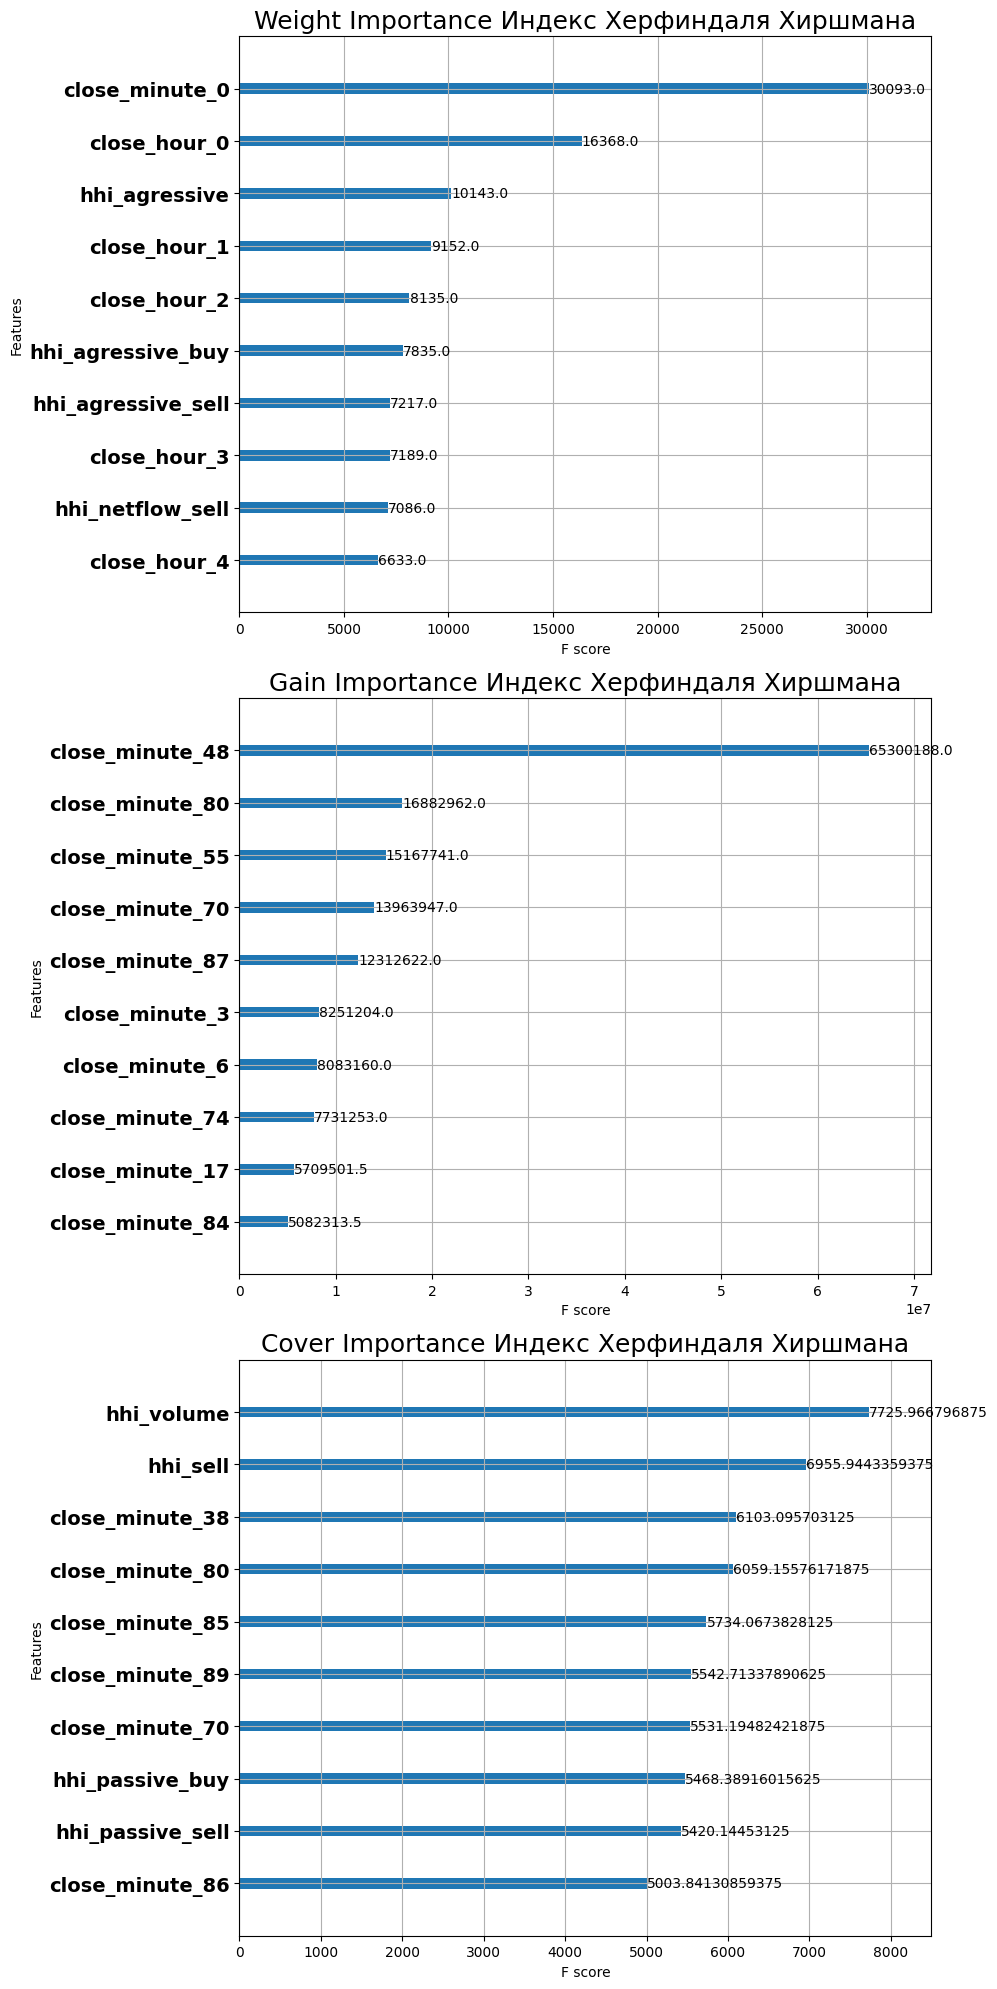

In [ ]:
list_hi2 = [item for item in list(final_df.columns) if 'hhi' in item]
current_columns = close_columns + list_hi2
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df[final_df.ticker != 'SIBN'], current_columns = current_columns, cat_features = cat_features, name_model = 'Индекс Херфиндаля Хиршмана')

**С информацией про OBSTATS**

Start training model 1
OBStats_info, На первом сплите кросс валидации метрики на тесте

MSE: 511.772351044582
RMSE: 22.622386059931475
MAE: 10.243358791085509
MAPE: 0.600997833902703
________________________________________
Start training model 2, (the second stage of validation)

OBStats_info, На втором сплите кросс валидации метрики на тесте
MSE: 481.8774470016628
RMSE: 21.95170715460788
MAE: 9.768436880229432
MAPE: 0.6439811867339418
________________________________________
Start training model 3, (the third stage of validation)

OBStats_info, На втором сплите кросс валидации метрики на тесте
MSE: 465.567059806029
RMSE: 21.577003031144734
MAE: 9.662104433786727
MAPE: 0.7005868636989124
________________________________________
MEAN MAPE ON CROSS VAL:  0.6485219614451857
________________________________________


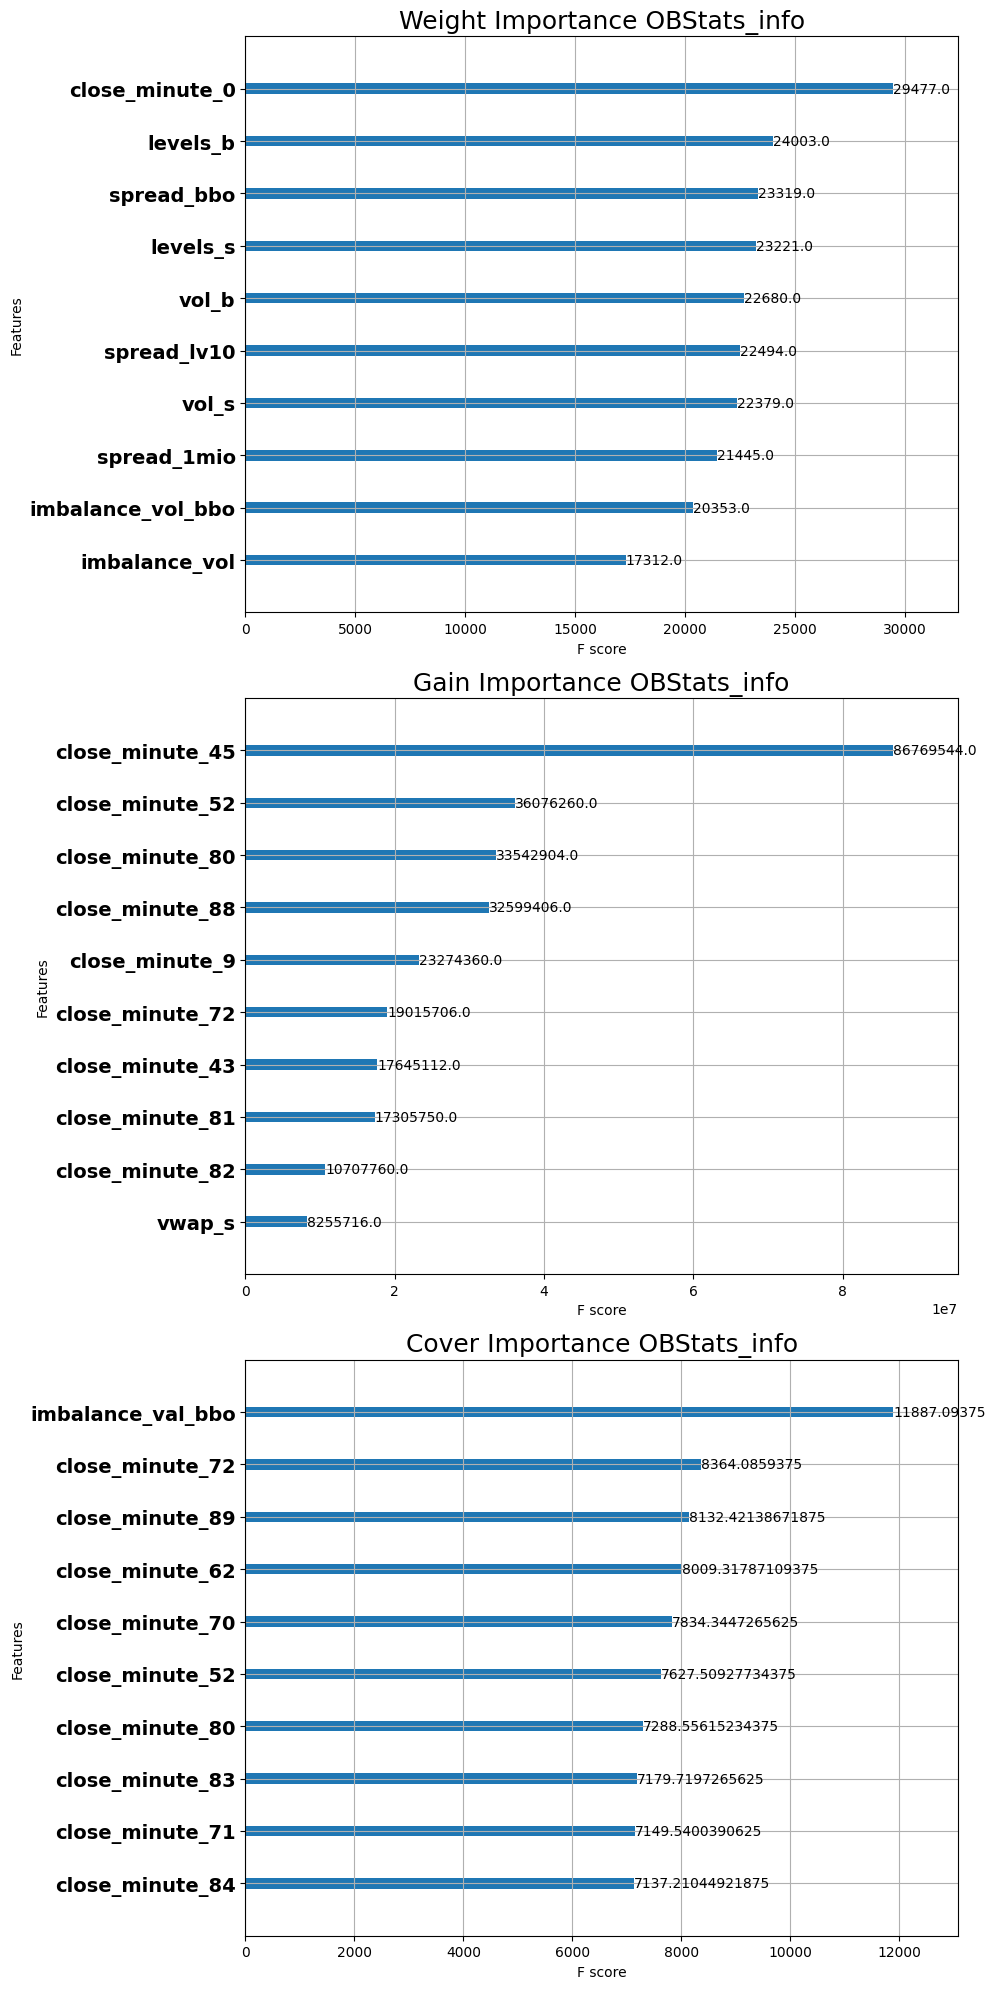

In [ ]:
current_columns = close_columns + list_obstats
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'OBStats_info')

**C информацией про orderstats**

In [ ]:
current_columns = close_columns + list_orderstats
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'OrderStats_info')

**С информацией про TRADESTATS**

Start training model 1
TradeStats_info, На первом сплите кросс валидации метрики на тесте

MSE: 3123116.9765019747
RMSE: 1767.2342732365664
MAE: 1327.7629957983195
MAPE: 100.0
________________________________________
Start training model 2, (the second stage of validation)

TradeStats_info, На втором сплите кросс валидации метрики на тесте
MSE: 64091.17338624972
RMSE: 253.16234590920055
MAE: 72.08737288323002
MAPE: 5.347471975837386
________________________________________
Start training model 3, (the third stage of validation)

TradeStats_info, На втором сплите кросс валидации метрики на тесте
MSE: 58665.60329689582
RMSE: 242.2098331961273
MAE: 133.97188180452073
MAPE: 11.93668296540396
________________________________________
MEAN MAPE ON CROSS VAL:  39.094718313747116
________________________________________


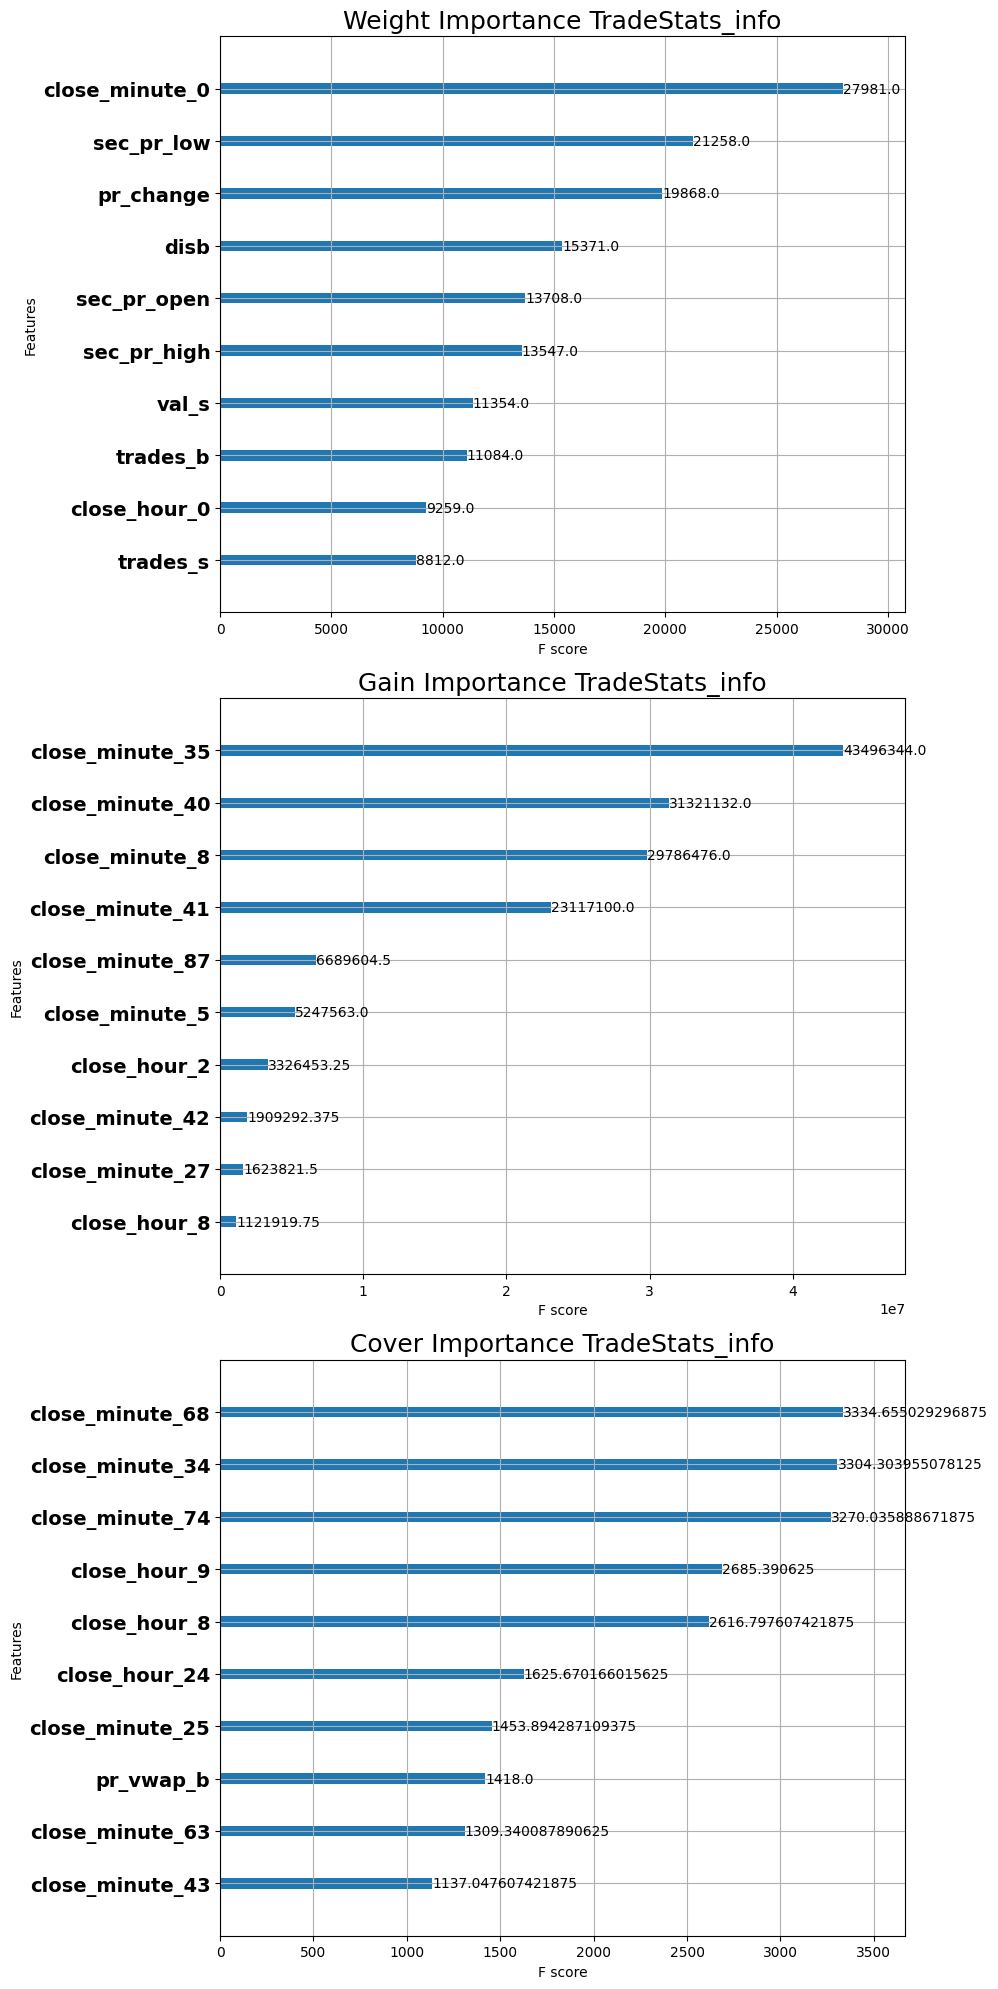

In [ ]:
current_columns = close_columns + list_tradestats
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df.dropna(), current_columns = current_columns, cat_features = cat_features, name_model = 'TradeStats_info')

**Фьючерсы Золота, Доллара, Нефти, Индекс Мосбиржи**

Start training model 1
Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи, На первом сплите кросс валидации метрики на тесте

MSE: 625.8984778379153
RMSE: 25.017963103296704
MAE: 11.259427714757924
MAPE: 0.6225618866916853
________________________________________
Start training model 2, (the second stage of validation)

Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи, На втором сплите кросс валидации метрики на тесте
MSE: 821.8947377365058
RMSE: 28.668706593365975
MAE: 12.29905990694776
MAPE: 0.7299260824225611
________________________________________
Start training model 3, (the third stage of validation)

Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи, На втором сплите кросс валидации метрики на тесте
MSE: 708.8065467471399
RMSE: 26.62342101885368
MAE: 12.380798468071534
MAPE: 0.7523929498672275
________________________________________
MEAN MAPE ON CROSS VAL:  0.7016269729938246
________________________________________


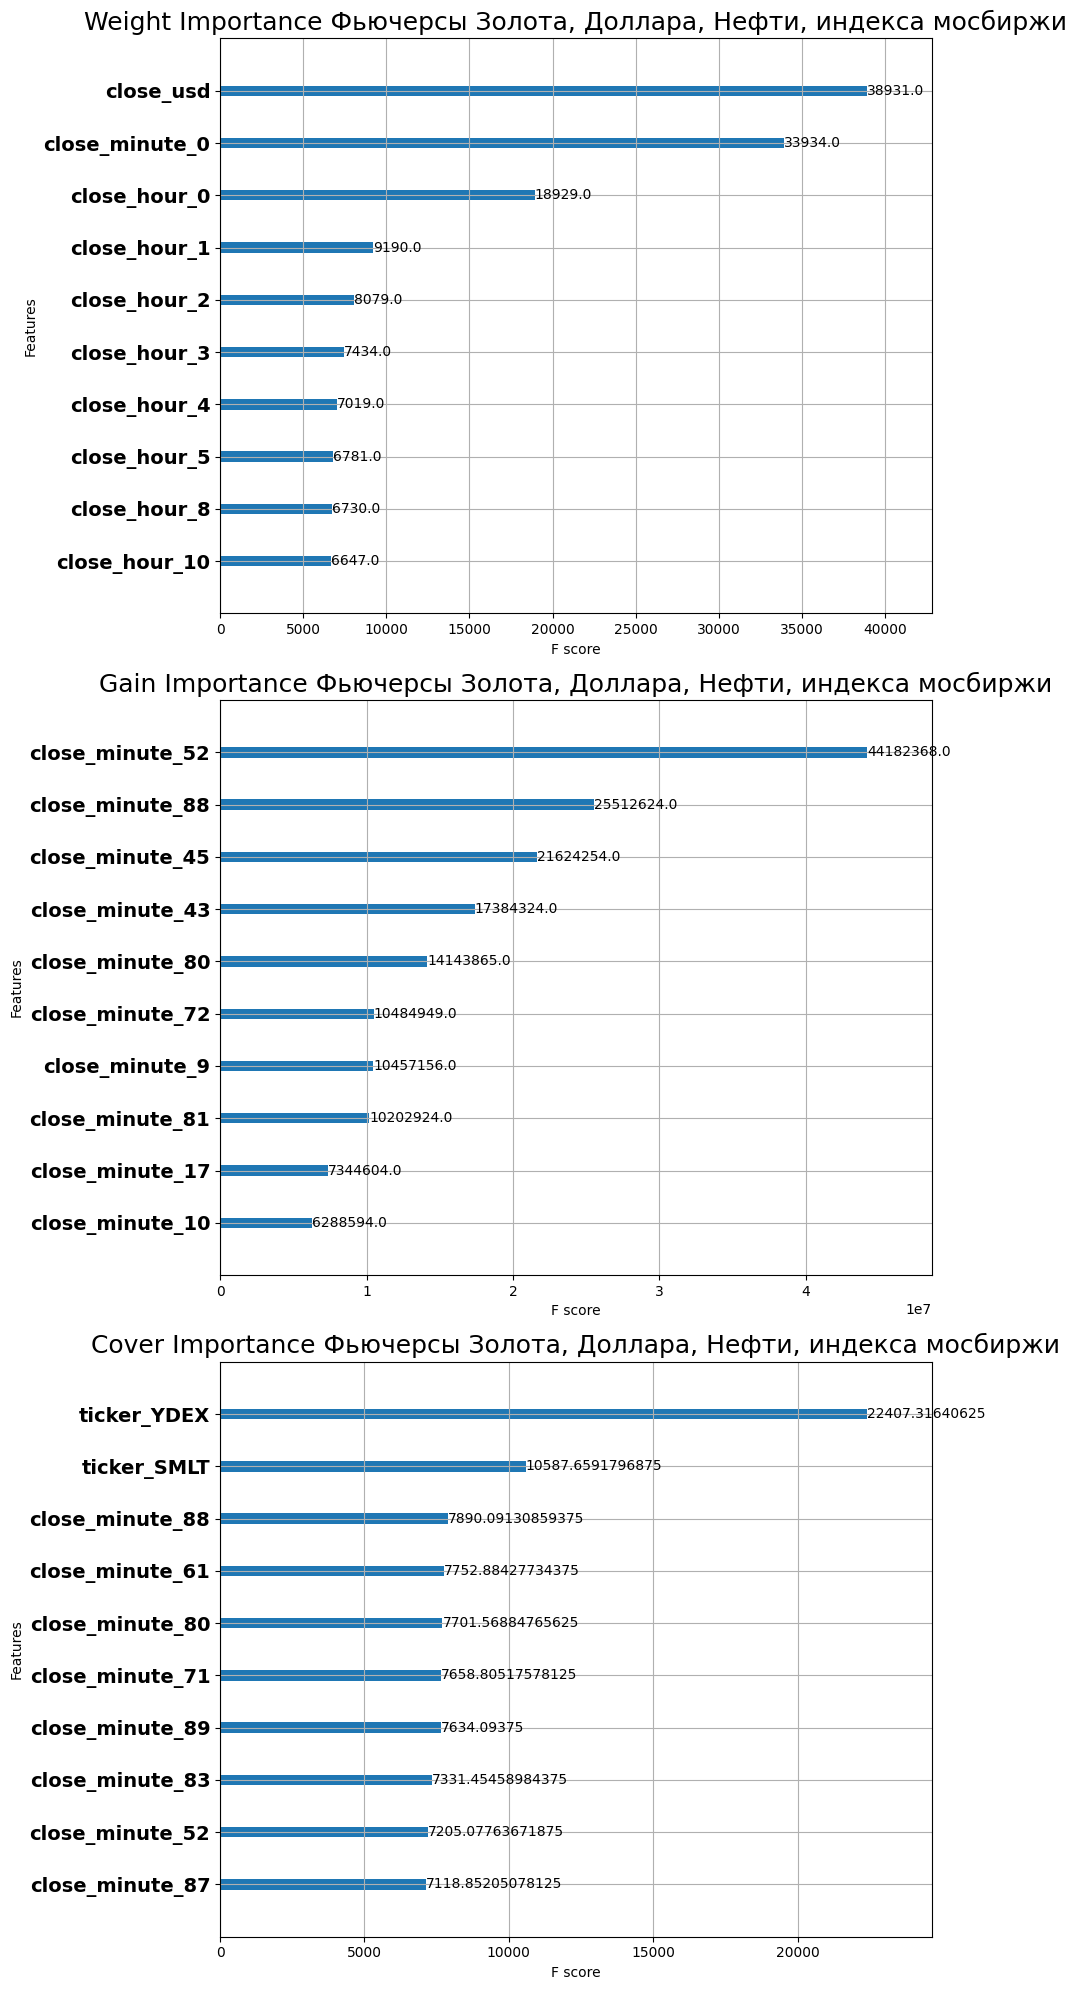

In [ ]:
current_columns = close_columns + [#'close_gold',
                                   'close_usd', 'close_moex',# 'close_oil'
                                   ]
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи')

**Новостной анализ**

In [ ]:
final_df[list_news] = final_df[list_news].astype(float)
close_columns = [col for col in window_columns1 + window_columns2 if 'close' in col]
current_columns = close_columns + list_news
cat_features = ['ticker']
count_xgboost_metrics(final_df = final_df, current_columns = current_columns, cat_features = cat_features, name_model = 'Новостной анализ')

**Итог**

In [43]:
df_metrics['Mean_MAPE'] = (df_metrics['MAPE1'] + df_metrics['MAPE2'] + df_metrics['MAPE3']) / 3
df_metrics['Mean_RMSE'] = (df_metrics['RMSE1'] + df_metrics['RMSE2'] + df_metrics['RMSE3']) / 3
df_metrics.sort_values(by = 'Mean_MAPE')

,Model,MSE1,RMSE1,MAE1,MAPE1,MSE2,RMSE2,MAE2,MAPE2,MSE3,RMSE3,MAE3,MAPE3,Mean_MAPE,Mean_RMSE
10,Модель с лучшими фичами,4.975700e+02,22.306277,10.143056,0.590802,433.407275,20.818436,9.095498,0.601164,477.128151,21.843263,9.587680,0.677842,0.623269,21.655992
5,OBStats_info,5.117724e+02,22.622386,10.243359,0.600998,481.877447,21.951707,9.768437,0.643981,465.567060,21.577003,9.662104,0.700587,0.648522,22.050365
6,OrderStats_info,6.233603e+02,24.967185,10.746303,0.629964,552.492774,23.505165,10.087995,0.651170,486.781759,22.063131,10.187947,0.674099,0.651745,23.511827
2,С полной информацией о свечах,6.273499e+02,25.046954,11.139850,0.628012,559.177543,23.646935,10.259378,0.655925,480.267666,21.915010,10.433969,0.692059,0.658665,23.536300
3,Показатели Технического анализа,6.473341e+02,25.442761,11.231784,0.637560,664.156201,25.771228,10.599158,0.656064,834.066529,28.880210,12.437536,0.730574,0.674733,26.698066
9,Новостной анализ,6.401235e+02,25.300123,11.200234,0.645123,620.987654,24.927654,10.954321,0.678934,590.456789,24.293456,11.300456,0.712456,0.678838,24.840411
1,"День недели, время",8.003486e+02,28.290432,12.077831,0.664342,603.085475,24.557799,10.307341,0.652055,882.757419,29.711234,12.959329,0.754742,0.690380,27.519822
0,Baseline_model,6.726148e+02,25.934817,11.833301,0.660906,642.185377,25.341377,10.582640,0.668850,583.825896,24.162489,11.687878,0.755696,0.695150,25.146228
8,"Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи",6.258985e+02,25.017963,11.259428,0.622562,821.894738,28.668707,12.299060,0.729926,708.806547,26.623421,12.380798,0.752393,0.701627,26.770030
4,Индекс Херфиндаля Хиршмана,8.916446e+02,29.860419,13.462042,0.745840,667.681611,25.839536,11.820542,0.755691,1172.565684,34.242746,13.997561,0.832810,0.778114,29.980900


In [45]:
df_metrics.to_csv('metrics_df231623101.csv')

In [ ]:
df_metrics

,Model,MSE1,RMSE1,MAE1,MAPE1,MSE2,RMSE2,MAE2,MAPE2,MSE3,RMSE3,MAE3,MAPE3,Mean_MAPE,Mean_RMSE
0,Baseline_model,6.726148e+02,25.934817,11.833301,0.660906,642.185377,25.341377,10.582640,0.668850,583.825896,24.162489,11.687878,0.755696,0.695150,25.146228
1,"День недели, время",8.003486e+02,28.290432,12.077831,0.664342,603.085475,24.557799,10.307341,0.652055,882.757419,29.711234,12.959329,0.754742,0.690380,27.519822
2,С полной информацией о свечах,6.273499e+02,25.046954,11.139850,0.628012,559.177543,23.646935,10.259378,0.655925,480.267666,21.915010,10.433969,0.692059,0.658665,23.536300
3,Показатели Технического анализа,6.473341e+02,25.442761,11.231784,0.637560,664.156201,25.771228,10.599158,0.656064,834.066529,28.880210,12.437536,0.730574,0.674733,26.698066
4,Индекс Херфиндаля Хиршмана,8.916446e+02,29.860419,13.462042,0.745840,667.681611,25.839536,11.820542,0.755691,1172.565684,34.242746,13.997561,0.832810,0.778114,29.980900
5,OBStats_info,5.117724e+02,22.622386,10.243359,0.600998,481.877447,21.951707,9.768437,0.643981,465.567060,21.577003,9.662104,0.700587,0.648522,22.050365
6,OrderStats_info,6.233603e+02,24.967185,10.746303,0.629964,552.492774,23.505165,10.087995,0.651170,486.781759,22.063131,10.187947,0.674099,0.651745,23.511827
7,TradeStats_info,3.123117e+06,1767.234273,1327.762996,100.000000,64091.173386,253.162346,72.087373,5.347472,58665.603297,242.209833,133.971882,11.936683,39.094718,754.202151
8,"Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи",6.258985e+02,25.017963,11.259428,0.622562,821.894738,28.668707,12.299060,0.729926,708.806547,26.623421,12.380798,0.752393,0.701627,26.770030
9,Новостной анализ,6.002127e+02,24.499842,9.834125,0.520145,382.981243,19.575932,7.489345,0.405891,263.349871,16.224654,7.119412,0.481290,0.469109,20.100143


# Обучение лучшей модели

Обучим, используя лучшие признаки

Start training model 1
Модель с лучшими фичами, На первом сплите кросс валидации метрики на тесте

MSE: 497.56999558813885
RMSE: 22.30627704454822
MAE: 10.143055663602723
MAPE: 0.5908017035257433
________________________________________
Start training model 2, (the second stage of validation)

Модель с лучшими фичами, На втором сплите кросс валидации метрики на тесте
MSE: 433.4072748175691
RMSE: 20.818435935909523
MAE: 9.095498090202426
MAPE: 0.6011642761494782
________________________________________
Start training model 3, (the third stage of validation)

Модель с лучшими фичами, На втором сплите кросс валидации метрики на тесте
MSE: 477.1281507470075
RMSE: 21.84326328063203
MAE: 9.587679605865874
MAPE: 0.6778423697293364
________________________________________
MEAN MAPE ON CROSS VAL:  0.6232694498015193
________________________________________


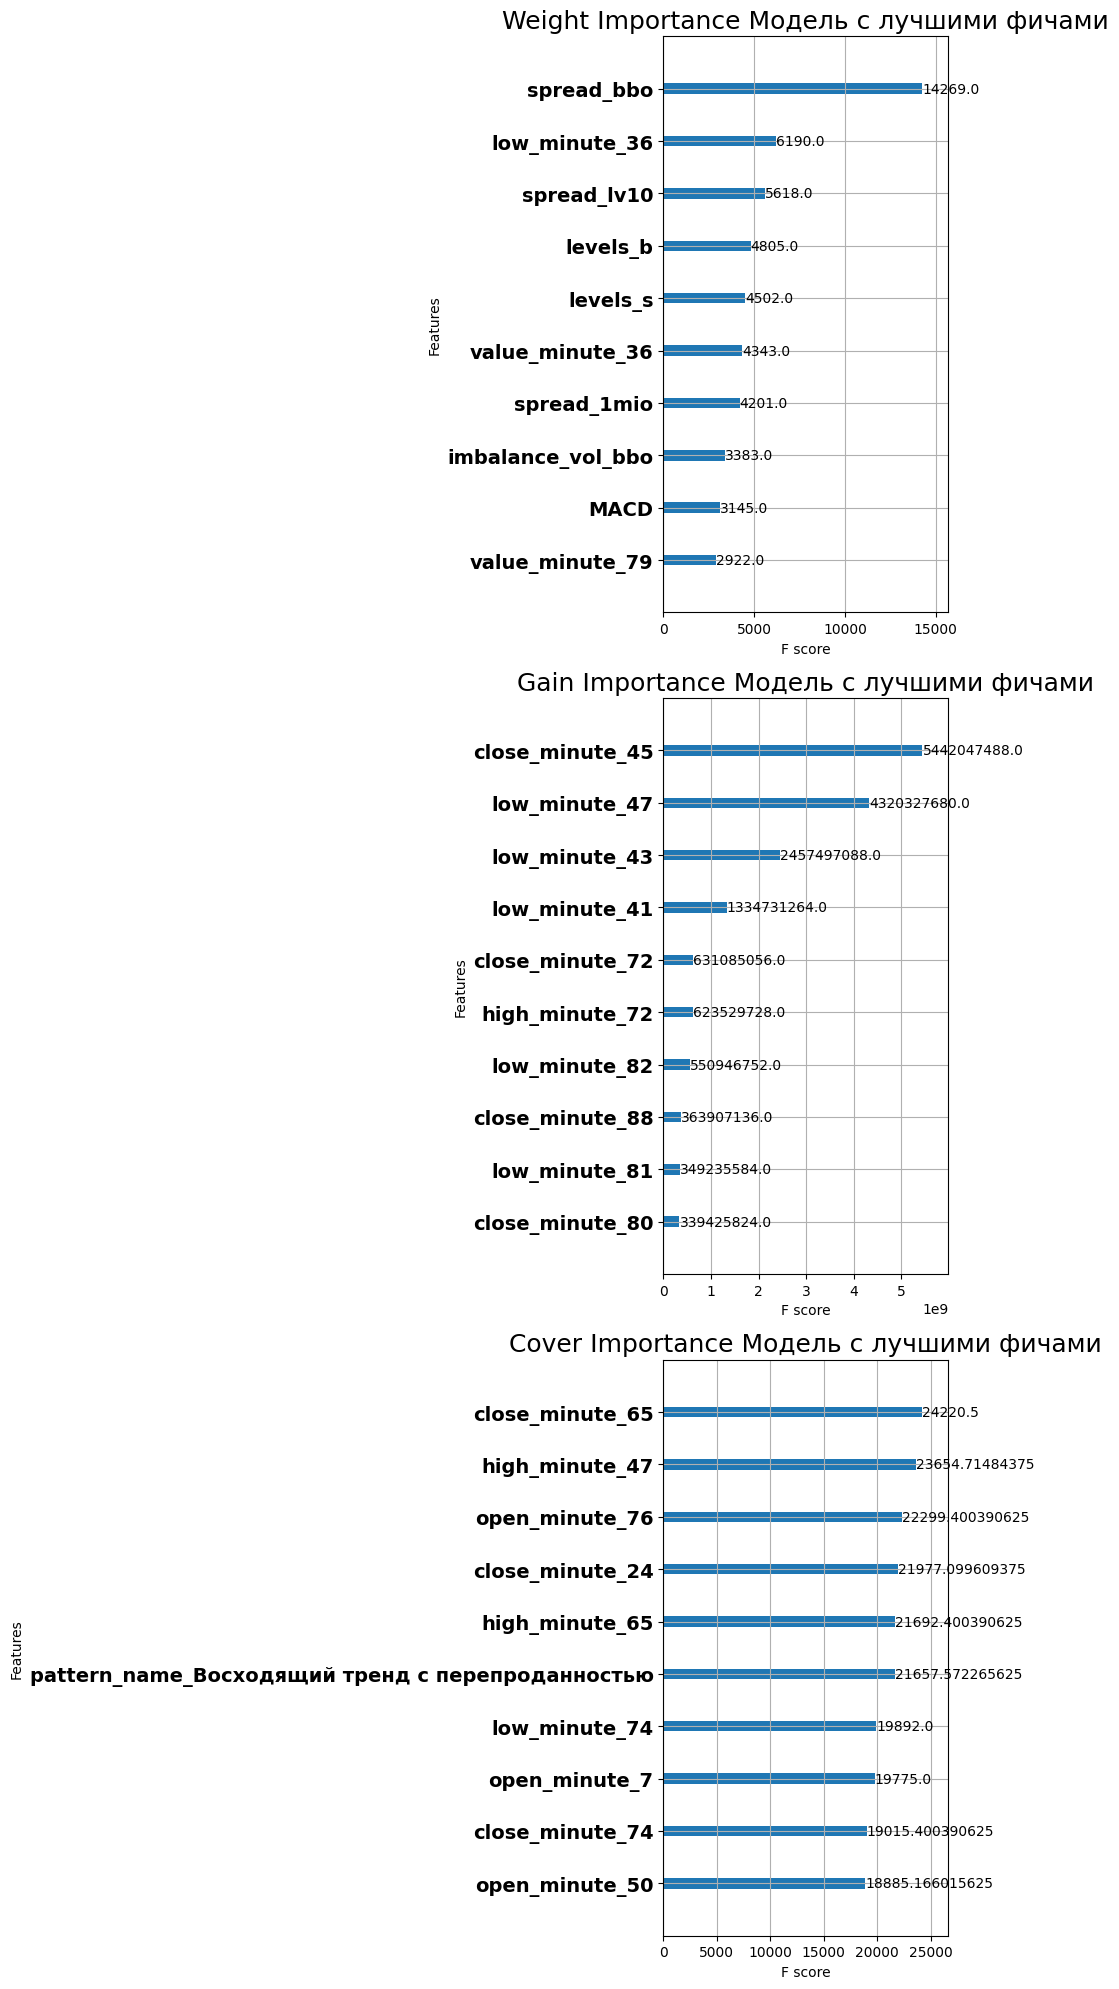

In [42]:
a = 0

current_columns = list_obstats + list_orderstats + window_columns1 + window_columns2 + indicator_columns
cat_features = ['ticker'] + ['CDLDOJI', 'pattern_name']


name_model = 'Модель с лучшими фичами'

if a == 0:
  df_all = final_df.copy()
  df_all['day_of_week'] = df_all['datetime'].dt.day_name()
  df_all['hour'] = df_all['datetime'].dt.hour

  df_all = df_all[current_columns + ['ticker', 'datetime', 'target']]

  df_all_encoded = pd.get_dummies(df_all, columns=cat_features)

  df_train1 = df_all_encoded[df_all_encoded.datetime < '2024-01-01'].reset_index(drop=True)
  df_test1 = df_all_encoded[(df_all_encoded.datetime >= '2024-01-01')&(df_all_encoded.datetime < '2024-06-01')].reset_index(drop=True)

  df_train2 = df_all_encoded[df_all_encoded.datetime < '2024-06-01'].reset_index(drop=True)
  df_test2 = df_all_encoded[(df_all_encoded.datetime >= '2024-06-01')&(df_all_encoded.datetime < '2024-08-01')].reset_index(drop=True)

  df_train3 = df_all_encoded[df_all_encoded.datetime < '2024-08-01'].reset_index(drop=True)
  df_test3 = df_all_encoded[df_all_encoded.datetime >= '2024-08-01'].reset_index(drop=True)

  X_train1 = df_train1.drop(columns = ['target', 'datetime'])
  y_train1 = df_train1['target']
  X_test1 = df_test1.drop(columns = ['target', 'datetime'])
  y_test1 = df_test1['target']

  X_train2 = df_train2.drop(columns = ['target', 'datetime'])
  y_train2 = df_train2['target']
  X_test2 = df_test2.drop(columns = ['target', 'datetime'])
  y_test2 = df_test2['target']

  X_train3 = df_train3.drop(columns = ['target', 'datetime'])
  y_train3 = df_train3['target']
  X_test3 = df_test3.drop(columns = ['target', 'datetime'])
  y_test3 = df_test3['target']

  #__________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)
  print('Start training model 1')
  XGB.fit(X_train1, y_train1, verbose=True)

  predictions = XGB.predict(X_test1)

  mse1 = mean_squared_error(y_test1, predictions)
  rmse1 = np.sqrt(mse1)
  mae1 = mean_absolute_error(y_test1, predictions)
  mape1 = np.mean(np.abs((y_test1 - predictions) / y_test1)) * 100

  print(f'{name_model}, На первом сплите кросс валидации метрики на тесте\n')
  print(f"MSE: {mse1}")
  print(f"RMSE: {rmse1}")
  print(f"MAE: {mae1}")
  print(f"MAPE: {mape1}")
  print('_' * 40)

  #____________________________________________

  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)

  print('Start training model 2, (the second stage of validation)\n')

  XGB.fit(X_train2, y_train2, verbose=True)

  predictions = XGB.predict(X_test2)

  mse2 = mean_squared_error(y_test2, predictions)
  rmse2 = np.sqrt(mse2)
  mae2 = mean_absolute_error(y_test2, predictions)
  mape2 = np.mean(np.abs((y_test2 - predictions) / y_test2)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse2}")
  print(f"RMSE: {rmse2}")
  print(f"MAE: {mae2}")
  print(f"MAPE: {mape2}")
  print('_' * 40)


  #________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)

  print('Start training model 3, (the third stage of validation)\n')

  XGB.fit(X_train3, y_train3, verbose=True)

  predictions = XGB.predict(X_test3)

  mse3 = mean_squared_error(y_test3, predictions)
  rmse3 = np.sqrt(mse3)
  mae3 = mean_absolute_error(y_test3, predictions)
  mape3 = np.mean(np.abs((y_test3 - predictions) / y_test3)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse3}")
  print(f"RMSE: {rmse3}")
  print(f"MAE: {mae3}")
  print(f"MAPE: {mape3}")
  print('_' * 40)

  print('MEAN MAPE ON CROSS VAL: ', (mape1 + mape2 + mape3) / 3)
  print('_' * 40)

  fig, axs = plt.subplots(3, 1, figsize=(10, 20))  # 3 строки, 1 колонка

  # Параметры для подписи осей
  importance_types = ['weight', 'gain', 'cover']
  titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']

  for i, importance_type in enumerate(importance_types):
      plt.sca(axs[i])  # Устанавливаем текущую ось
      plot_importance(XGB, importance_type=importance_type, max_num_features=10, ax=axs[i])
      axs[i].set_title(f'{titles[i]} {name_model}', fontsize=18)

      # Устанавливаем стиль для оси Y (названия фичей)
      for tick in axs[i].yaxis.get_majorticklabels():
          tick.set_fontsize(14)  # Размер шрифта для названий фичей
          tick.set_fontweight('bold')  # Жирный шрифт

  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/dfs_stocks/plots/{name_model}_feature_importance3.png')
  plt.show()

new_row = {
    'Model': name_model,
    'MSE1': mse1,
    'RMSE1': rmse1,
    'MAE1': mae1,
    'MAPE1': mape1,
    'MSE2': mse2,
    'RMSE2': rmse2,
    'MAE2': mae2,
    'MAPE2': mape2,
    'MSE3': mse3,
    'RMSE3': rmse3,
    'MAE3': mae3,
    'MAPE3': mape3,
    'Mean_MAPE': (mape1 + mape2 + mape3) / 3,
    'Mean_RMSE': (rmse1 + rmse2 + rmse3) / 3
}



new_row_df = pd.DataFrame([new_row])

df_metrics = pd.concat([df_metrics, new_row_df], ignore_index=True)

In [ ]:
df_metrics = pd.concat([df_metrics, new_row_df], ignore_index=True)

In [ ]:
df_metrics.to_csv('/content/drive/MyDrive/metrics_df11092310.csv')

**Обучение модели для бота**

In [46]:
current_columns = list_obstats + window_columns1 + window_columns2 + indicator_columns
cat_features = ['ticker'] + ['CDLDOJI', 'pattern_name']

df_all = final_df.copy()
df_all['day_of_week'] = df_all['datetime'].dt.day_name()
df_all['hour'] = df_all['datetime'].dt.hour

df_all = df_all[current_columns + ['ticker', 'datetime', 'target']]

df_all_encoded = pd.get_dummies(df_all, columns=cat_features)


df_train = df_all_encoded.reset_index(drop=True)

X_train = df_train.drop(columns = ['target', 'datetime'])
y_train = df_train['target']

XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.05,
                    n_estimators = 8000,
                    verbosity=0)

XGB.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=8000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_train.columns

Index(['spread_bbo', 'spread_lv10', 'spread_1mio', 'levels_b', 'levels_s',
       'vol_b', 'vol_s', 'val_b', 'val_s', 'imbalance_vol_bbo',
       ...
       'ticker_VKCO', 'ticker_YDEX', 'CDLDOJI_0', 'CDLDOJI_100',
       'pattern_name_Восходящий тренд с перекупленностью',
       'pattern_name_Восходящий тренд с перепроданностью',
       'pattern_name_Нет четкого паттерна', 'pattern_name_Перекупленность',
       'pattern_name_Перепроданность', 'pattern_name_Формирование Doji'],
      dtype='object', length=746)

In [ ]:
X_train.columns.to_series().to_csv('/content/drive/MyDrive/column_names2.csv', index=False)

In [ ]:
X_train.columns.to_series().to_csv('/content/column_names2.csv', index=False)

In [47]:
XGB.save_model('/content/drive/MyDrive/xgb_model3.bin')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [48]:
XGB.save_model('/content/xgb_model3.bin')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:39:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Open Interest

Отдельно стоило рассмотреть Open Interest. Но для него нужны фьючерсы этой компании. Взяли проверить гипотезы конкретно для сбера

In [49]:
final_df_sber = final_df[final_df['ticker'] == 'SBER']
sber325_rf = pd.read_csv('/content/drive/MyDrive/sber325_rf.csv')
sber325_pr = pd.read_csv('/content/drive/MyDrive/sber325_pr.csv')
sber325_rf['datetime'] = pd.to_datetime(sber325_rf['datetime'])
sber325_pr = sber325_pr.sort_values(by = 'datetime')
sber325_pr['datetime'] = pd.to_datetime(sber325_pr['datetime'])
sber325_pr = sber325_pr.sort_values(by = 'datetime')
data_pr = []
data_rf = []

for index, row in final_df_sber.iterrows():
      row_datetime = row['datetime']
      if len(sber325_pr[sber325_pr['datetime'] <= row_datetime]) > 0:
        closest_pr_row = sber325_pr[sber325_pr['datetime'] <= row_datetime].iloc[-1]
        data_pr.append(closest_pr_row[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']])
      else:
          data_pr.append([None, None, None, None, None])


      if len(sber325_rf[sber325_rf['datetime'] <= row_datetime]) > 0:
        closest_rf_row = sber325_rf[sber325_rf['datetime'] <= row_datetime].iloc[-1]
        data_rf.append(closest_rf_row[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']])
      else:
        data_rf.append([None, None, None, None, None])

data_pr_df = pd.DataFrame(data_pr)
data_pr_df.columns = ['pos_pr', 'pos_long_pr', 'pos_short_pr', 'pos_long_num_pr', 'pos_short_num_pr']
data_rf_df = pd.DataFrame(data_rf)
data_rf_df.columns = ['pos_rf', 'pos_long_rf', 'pos_short_rf', 'pos_long_num_rf', 'pos_short_num_rf']

final_df_sber = pd.concat([final_df_sber.reset_index(drop=True), data_pr_df.reset_index(drop=True), data_rf_df.reset_index(drop=True)], axis=1)


In [50]:
df_metrics_OI = pd.DataFrame(columns = [
            'Model',
            'MSE1',
            'RMSE1',
            'MAE1',
            'MAPE1',
            'MSE2',
            'RMSE2',
            'MAE2',
            'MAPE2',
            'MSE3',
            'RMSE3'
            ])

In [59]:
df_metrics

,Model,MSE1,RMSE1,MAE1,MAPE1,MSE2,RMSE2,MAE2,MAPE2,MSE3,RMSE3,MAE3,MAPE3,Mean_MAPE,Mean_RMSE
0,Baseline_model,6.726148e+02,25.934817,11.833301,0.660906,642.185377,25.341377,10.582640,0.668850,583.825896,24.162489,11.687878,0.755696,0.695150,25.146228
1,"День недели, время",8.003486e+02,28.290432,12.077831,0.664342,603.085475,24.557799,10.307341,0.652055,882.757419,29.711234,12.959329,0.754742,0.690380,27.519822
2,С полной информацией о свечах,6.273499e+02,25.046954,11.139850,0.628012,559.177543,23.646935,10.259378,0.655925,480.267666,21.915010,10.433969,0.692059,0.658665,23.536300
3,Показатели Технического анализа,6.473341e+02,25.442761,11.231784,0.637560,664.156201,25.771228,10.599158,0.656064,834.066529,28.880210,12.437536,0.730574,0.674733,26.698066
4,Индекс Херфиндаля Хиршмана,8.916446e+02,29.860419,13.462042,0.745840,667.681611,25.839536,11.820542,0.755691,1172.565684,34.242746,13.997561,0.832810,0.778114,29.980900
5,OBStats_info,5.117724e+02,22.622386,10.243359,0.600998,481.877447,21.951707,9.768437,0.643981,465.567060,21.577003,9.662104,0.700587,0.648522,22.050365
6,OrderStats_info,6.233603e+02,24.967185,10.746303,0.629964,552.492774,23.505165,10.087995,0.651170,486.781759,22.063131,10.187947,0.674099,0.651745,23.511827
7,TradeStats_info,3.123117e+06,1767.234273,1327.762996,100.000000,64091.173386,253.162346,72.087373,5.347472,58665.603297,242.209833,133.971882,11.936683,39.094718,754.202151
8,"Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи",6.258985e+02,25.017963,11.259428,0.622562,821.894738,28.668707,12.299060,0.729926,708.806547,26.623421,12.380798,0.752393,0.701627,26.770030
9,Новостной анализ,6.401235e+02,25.300123,11.200234,0.645123,620.987654,24.927654,10.954321,0.678934,590.456789,24.293456,11.300456,0.712456,0.678838,24.840411


In [51]:
def count_xgboost_metrics_sber(final_df, current_columns, cat_features, name_model):
  global df_metrics_OI
  df_all = final_df.copy()
  df_all['day_of_week'] = df_all['datetime'].dt.day_name()
  df_all['hour'] = df_all['datetime'].dt.hour

  df_all = df_all[current_columns + ['ticker', 'datetime', 'target']]

  df_all_encoded = pd.get_dummies(df_all, columns=cat_features)

  df_train1 = df_all_encoded[df_all_encoded.datetime < '2024-01-01'].reset_index(drop=True)
  df_test1 = df_all_encoded[(df_all_encoded.datetime >= '2024-01-01')&(df_all_encoded.datetime < '2024-06-01')].reset_index(drop=True)

  df_train2 = df_all_encoded[df_all_encoded.datetime < '2024-06-01'].reset_index(drop=True)
  df_test2 = df_all_encoded[(df_all_encoded.datetime >= '2024-06-01')&(df_all_encoded.datetime < '2024-08-01')].reset_index(drop=True)

  df_train3 = df_all_encoded[df_all_encoded.datetime < '2024-08-01'].reset_index(drop=True)
  df_test3 = df_all_encoded[df_all_encoded.datetime >= '2024-08-01'].reset_index(drop=True)

  X_train1 = df_train1.drop(columns = ['target', 'datetime'])
  y_train1 = df_train1['target']
  X_test1 = df_test1.drop(columns = ['target', 'datetime'])
  y_test1 = df_test1['target']

  X_train2 = df_train2.drop(columns = ['target', 'datetime'])
  y_train2 = df_train2['target']
  X_test2 = df_test2.drop(columns = ['target', 'datetime'])
  y_test2 = df_test2['target']

  X_train3 = df_train3.drop(columns = ['target', 'datetime'])
  y_train3 = df_train3['target']
  X_test3 = df_test3.drop(columns = ['target', 'datetime'])
  y_test3 = df_test3['target']

  #__________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.025,
                    n_estimators = 5000,
                    verbosity=0)
  print('Start training model 1')
  XGB.fit(X_train1, y_train1, verbose=True)

  predictions = XGB.predict(X_test1)

  mse1 = mean_squared_error(y_test1, predictions)
  rmse1 = np.sqrt(mse1)
  mae1 = mean_absolute_error(y_test1, predictions)
  mape1 = np.mean(np.abs((y_test1 - predictions) / y_test1)) * 100

  print(f'{name_model}, На первом сплите кросс валидации метрики на тесте\n')
  print(f"MSE: {mse1}")
  print(f"RMSE: {rmse1}")
  print(f"MAE: {mae1}")
  print(f"MAPE: {mape1}")
  print('_' * 40)

  #____________________________________________

  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.025,
                    n_estimators = 5000,
                    verbosity=0)

  print('Start training model 2, (the second stage of validation)\n')

  XGB.fit(X_train2, y_train2, verbose=True)

  predictions = XGB.predict(X_test2)

  mse2 = mean_squared_error(y_test2, predictions)
  rmse2 = np.sqrt(mse2)
  mae2 = mean_absolute_error(y_test2, predictions)
  mape2 = np.mean(np.abs((y_test2 - predictions) / y_test2)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse2}")
  print(f"RMSE: {rmse2}")
  print(f"MAE: {mae2}")
  print(f"MAPE: {mape2}")
  print('_' * 40)


  #________________________________________________
  XGB = XGBRegressor(tree_method='gpu_hist',
                    learning_rate = 0.025,
                    n_estimators = 5000,
                    verbosity=0)

  print('Start training model 3, (the third stage of validation)\n')

  XGB.fit(X_train3, y_train3, verbose=True)

  predictions = XGB.predict(X_test3)

  mse3 = mean_squared_error(y_test3, predictions)
  rmse3 = np.sqrt(mse3)
  mae3 = mean_absolute_error(y_test3, predictions)
  mape3 = np.mean(np.abs((y_test3 - predictions) / y_test3)) * 100

  print(f'{name_model}, На втором сплите кросс валидации метрики на тесте')
  print(f"MSE: {mse3}")
  print(f"RMSE: {rmse3}")
  print(f"MAE: {mae3}")
  print(f"MAPE: {mape3}")
  print('_' * 40)

  #______________________________________________

  if df_metrics_OI is not None and not df_metrics_OI.empty:
        df_metrics_OI = pd.concat([df_metrics, pd.DataFrame({
            'Model': [name_model],
            'MSE1': [mse1],
            'RMSE1': [rmse1],
            'MAE1': [mae1],
            'MAPE1': [mape1],
            'MSE2': [mse2],
            'RMSE2': [rmse2],
            'MAE2': [mae2],
            'MAPE2': [mape2],
            'MSE3': [mse3],
            'RMSE3': [rmse3],
            'MAE3': [mae3],
            'MAPE3': [mape3]
        })], ignore_index=True)
  else:
        df_metrics_OI = pd.DataFrame({
            'Model': [name_model],
            'MSE1': [mse1],
            'RMSE1': [rmse1],
            'MAE1': [mae1],
            'MAPE1': [mape1],
            'MSE2': [mse2],
            'RMSE2': [rmse2],
            'MAE2': [mae2],
            'MAPE2': [mape2],
            'MSE3': [mse3],
            'RMSE3': [rmse3],
            'MAE3': [mae3],
            'MAPE3': [mape3]
        })

  print('MEAN MAPE ON CROSS VAL: ', (mape1 + mape2 + mape3) / 3)
  print('_' * 40)


# Создаем три графика одного размера, расположенные друг под другом
  fig, axs = plt.subplots(3, 1, figsize=(10, 20))  # 3 строки, 1 колонка

  # Параметры для подписи осей
  importance_types = ['weight', 'gain', 'cover']
  titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']

  for i, importance_type in enumerate(importance_types):
      plt.sca(axs[i])  # Устанавливаем текущую ось
      plot_importance(XGB, importance_type=importance_type, max_num_features=10, ax=axs[i])
      axs[i].set_title(f'{titles[i]} {name_model}', fontsize=18)

      # Устанавливаем стиль для оси Y (названия фичей)
      for tick in axs[i].yaxis.get_majorticklabels():
          tick.set_fontsize(14)  # Размер шрифта для названий фичей
          tick.set_fontweight('bold')  # Жирный шрифт

  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/dfs_stocks/plots/{name_model}_feature_importance3.png')
  plt.show()

Start training model 1
Sber_fith_OI, На первом сплите кросс валидации метрики на тесте

MSE: 1.3820176058426576
RMSE: 1.1755924488710607
MAE: 0.8680331278050192
MAPE: 0.29084270721795896
________________________________________
Start training model 2, (the second stage of validation)

Sber_fith_OI, На втором сплите кросс валидации метрики на тесте
MSE: 1.7754795378054373
RMSE: 1.3324712146254558
MAE: 0.8553374565972233
MAPE: 0.28102586046167066
________________________________________
Start training model 3, (the third stage of validation)

Sber_fith_OI, На втором сплите кросс валидации метрики на тесте
MSE: 1.6590449888288188
RMSE: 1.2880392031412782
MAE: 0.9474583374023429
MAPE: 0.35893932905003056
________________________________________
MEAN MAPE ON CROSS VAL:  0.3102692989098867
________________________________________


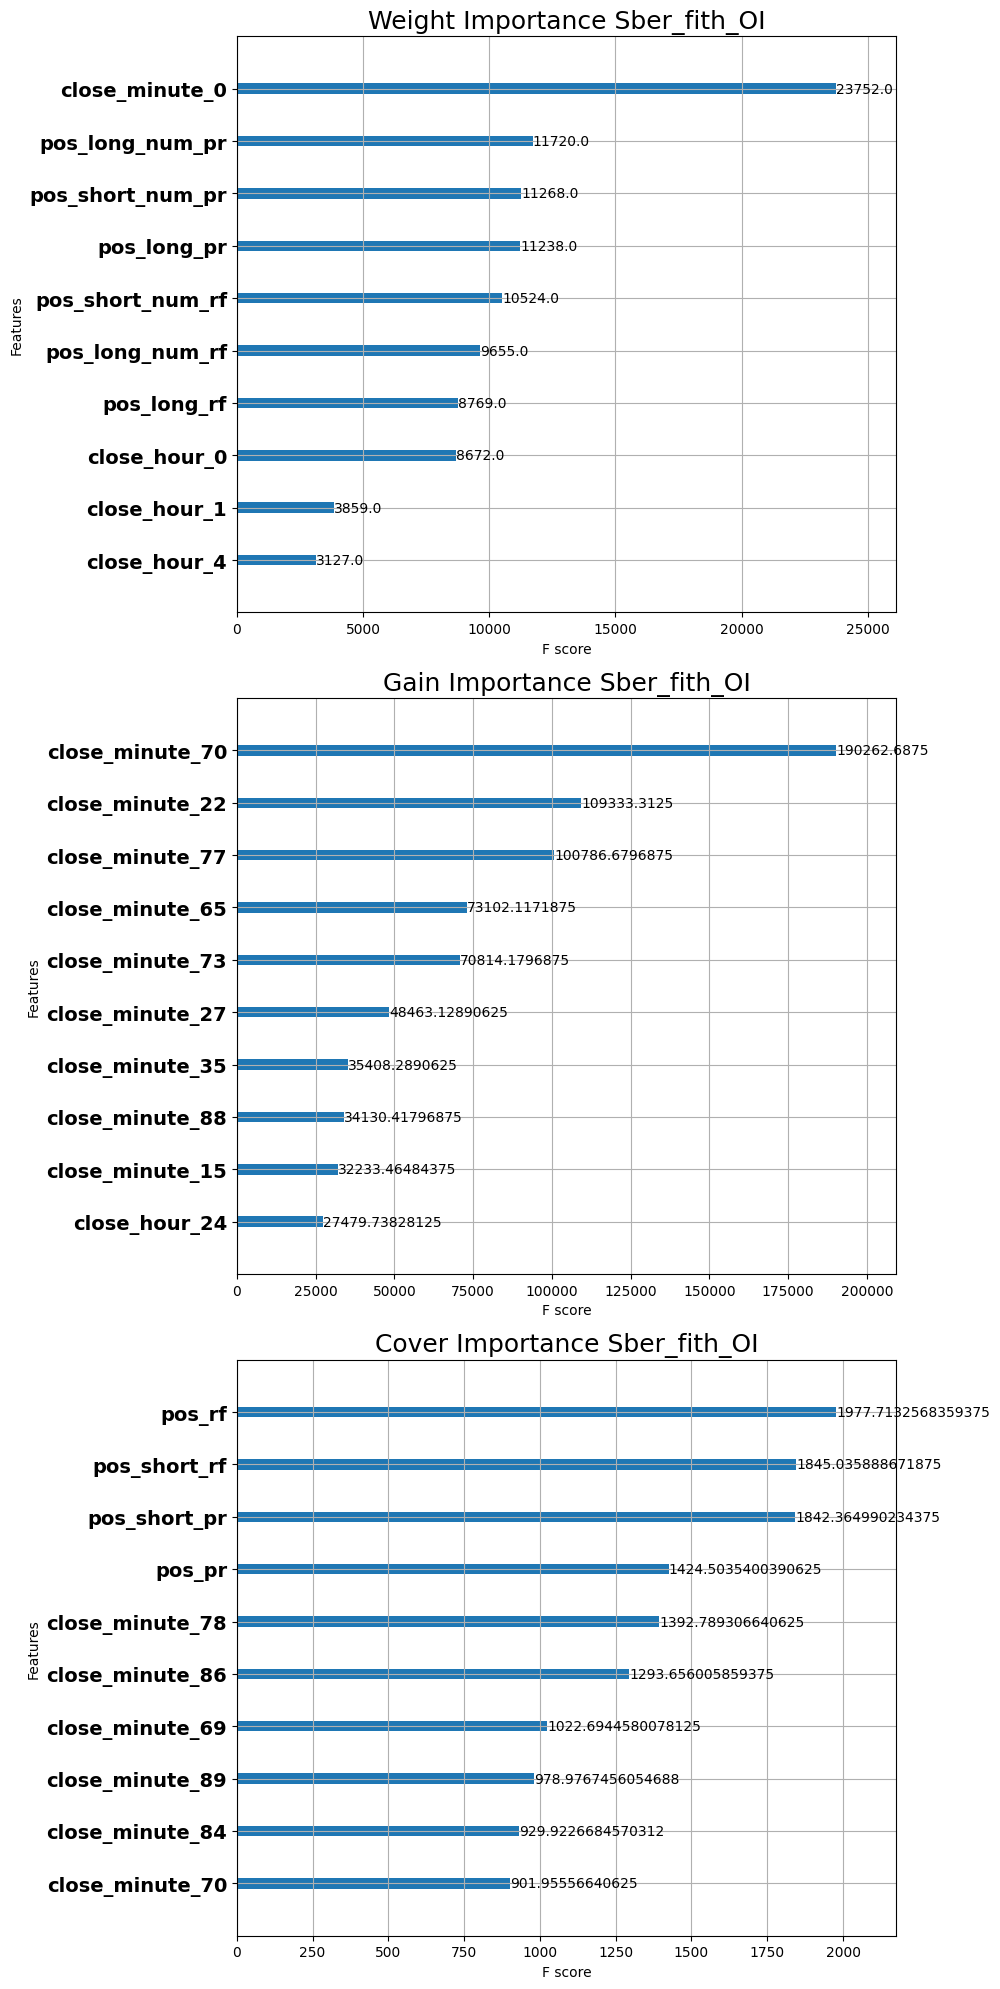

In [52]:
current_columns = close_columns + ['pos_pr', 'pos_long_pr', 'pos_short_pr', 'pos_long_num_pr', 'pos_short_num_pr'] + ['pos_rf', 'pos_long_rf', 'pos_short_rf', 'pos_long_num_rf', 'pos_short_num_rf']
cat_features = ['ticker']
count_xgboost_metrics_sber(final_df = final_df_sber.dropna(subset = 'pos_pr'), current_columns = current_columns, cat_features = cat_features, name_model = 'Sber_fith_OI')

Start training model 1
Sber_baseline_model, На первом сплите кросс валидации метрики на тесте

MSE: 1.0415756473714761
RMSE: 1.0205761350195663
MAE: 0.7473671952917216
MAPE: 0.2521079649378435
________________________________________
Start training model 2, (the second stage of validation)

Sber_baseline_model, На втором сплите кросс валидации метрики на тесте
MSE: 1.8178922717842891
RMSE: 1.348292353973829
MAE: 0.8512756024718914
MAPE: 0.2789521409248547
________________________________________
Start training model 3, (the third stage of validation)

Sber_baseline_model, На втором сплите кросс валидации метрики на тесте
MSE: 1.3860904998420893
RMSE: 1.1773234474188006
MAE: 0.850776501464842
MAPE: 0.32284176007470783
________________________________________
MEAN MAPE ON CROSS VAL:  0.28463395531246866
________________________________________


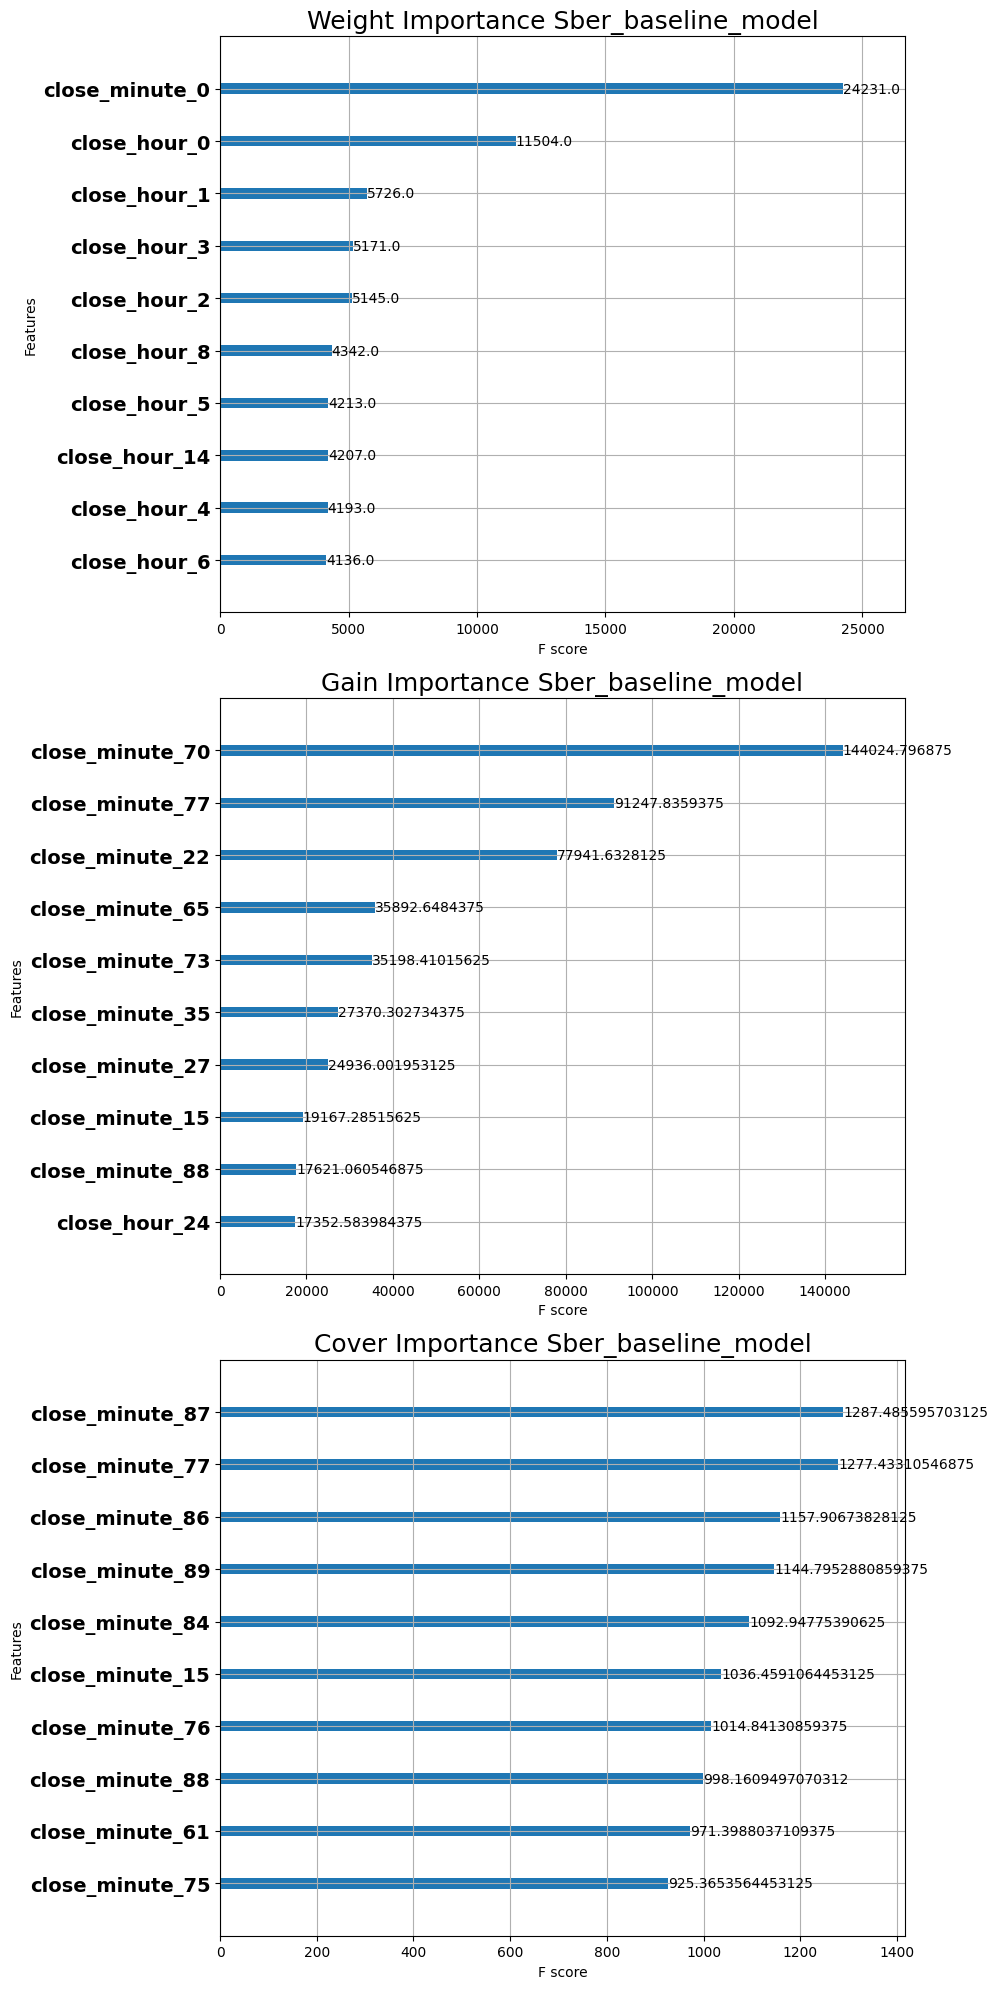

In [53]:
current_columns = close_columns
cat_features = ['ticker']
count_xgboost_metrics_sber(final_df = final_df_sber.dropna(subset = 'pos_pr'), current_columns = current_columns, cat_features = cat_features, name_model = 'Sber_baseline_model')

In [55]:
df_metrics_OI = df_metrics_OI.iloc[-2:]

In [56]:
df_metrics_OI['Mean_MAPE'] = (df_metrics_OI['MAPE1'] + df_metrics_OI['MAPE2'] + df_metrics_OI['MAPE3']) / 3
df_metrics_OI['Mean_RMSE'] = (df_metrics_OI['RMSE1'] + df_metrics_OI['RMSE2'] + df_metrics_OI['RMSE3']) / 3

<ipython-input-56-52be94c8efce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_OI['Mean_MAPE'] = (df_metrics_OI['MAPE1'] + df_metrics_OI['MAPE2'] + df_metrics_OI['MAPE3']) / 3
<ipython-input-56-52be94c8efce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_OI['Mean_RMSE'] = (df_metrics_OI['RMSE1'] + df_metrics_OI['RMSE2'] + df_metrics_OI['RMSE3']) / 3


In [57]:
df_metrics_OI

,Model,MSE1,RMSE1,MAE1,MAPE1,MSE2,RMSE2,MAE2,MAPE2,MSE3,RMSE3,MAE3,MAPE3,Mean_MAPE,Mean_RMSE
10,Модель с лучшими фичами,497.569996,22.306277,10.143056,0.590802,433.407275,20.818436,9.095498,0.601164,477.128151,21.843263,9.587680,0.677842,0.623269,21.655992
11,Sber_baseline_model,1.041576,1.020576,0.747367,0.252108,1.817892,1.348292,0.851276,0.278952,1.386090,1.177323,0.850777,0.322842,0.284634,1.182064


In [58]:
df_metrics_OI.to_csv('/content/metrics_OI.csv')

In [ ]:
df_metrics

,Model,MSE1,RMSE1,MAE1,MAPE1,MSE2,RMSE2,MAE2,MAPE2,MSE3,RMSE3,MAE3,MAPE3,Mean_MAPE,Mean_RMSE
0,Baseline_model,5.805406e+02,24.094400,10.227800,0.531700,375.968300,19.389900,7.645100,0.420500,310.829300,17.630400,7.687500,0.486100,0.479433,20.371567
1,"День недели, время",7.134187e+02,26.709900,10.543700,0.535000,374.056500,19.340500,7.692100,0.404600,762.836500,27.619500,10.107400,0.526300,0.488633,24.556633
2,С полной информацией о свечах,5.670842e+02,23.813500,9.734600,0.494800,316.263400,17.783800,7.318400,0.390400,302.722700,17.398900,7.408500,0.457400,0.447533,19.665400
3,Показатели Технического анализа,5.826860e+02,24.138900,9.724300,0.499600,367.266100,19.164200,7.240000,0.369900,645.712100,25.410900,8.089600,0.446600,0.438700,22.904667
4,Индекс Херфиндаля Хиршмана,9.031427e+02,30.052300,12.029100,0.611300,426.078700,20.641700,8.837300,0.509200,892.026800,29.866800,10.376300,0.578800,0.566433,26.853600
5,OBStats_info,4.500631e+02,21.214700,9.003800,0.479600,240.085400,15.494700,6.248100,0.356000,396.886400,19.922000,6.683800,0.453800,0.429800,18.877133
6,OrderStats_info,4.995566e+02,22.350800,8.810800,0.468900,298.573300,17.279300,6.747000,0.366100,418.423900,20.455400,7.173500,0.414100,0.416367,20.028500
7,TradeStats_info,3.123735e+06,1767.409000,1327.931100,100.000000,60753.013500,246.481300,66.023800,5.052100,58661.012300,242.200400,130.987700,11.835300,38.962467,752.030233
8,"Фьючерсы Золота, Доллара, Нефти, индекса мосбиржи",6.129834e+02,24.758500,10.129800,0.511800,602.406400,24.544000,9.194000,0.458400,258.672000,16.083300,7.229800,0.445600,0.471933,21.795267
9,Модель с лучшими фичами,4.537497e+02,21.301400,8.801257,0.457460,241.166489,15.529536,6.066846,0.329497,321.729664,17.936824,6.237202,0.421023,0.402660,18.255920
